In [16]:
import sys, os
sys.path.append(os.path.abspath(".."))  # add project root
import pandas as pd
pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

from pipelines.pipeline_runner import run_full_pipeline
from utils.ml_utils import prepare_stage3_dataset, prepare_X_y



In [17]:
dfs = run_full_pipeline()  # uses default RAW_FILE by config

df_raw = dfs["stage0"]
df_stage1 = dfs["stage1"]
df_stage2 = dfs["stage2"]
df_stage3 = dfs["stage3"]


KeyError: 'stage3'

In [19]:
df_stage3=pd.read_csv('../data/clean/clean_dataset_stage3_v4.csv')

In [21]:
sorted(df_stage3['property_type'].unique())


['Apartment', 'House']

In [ ]:
df_stage3.reset_index(drop=True, inplace=True)
df_stage3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21647 entries, 0 to 21646
Data columns (total 80 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   url                                            21647 non-null  string 
 1   property_id                                    21647 non-null  string 
 2   price                                          21647 non-null  float64
 3   rooms                                          21647 non-null  float64
 4   area                                           21647 non-null  float64
 5   state                                          21647 non-null  float64
 6   facades_number                                 21647 non-null  float64
 7   is_furnished                                   21647 non-null  float64
 8   has_terrace                                    21647 non-null  float64
 9   has_garden                                     216

Linear Regression

In [ ]:
df_stage3.describe(include='all')

Linear Regression
MAE: 82172.49078435542
R²: 0.597493924757746


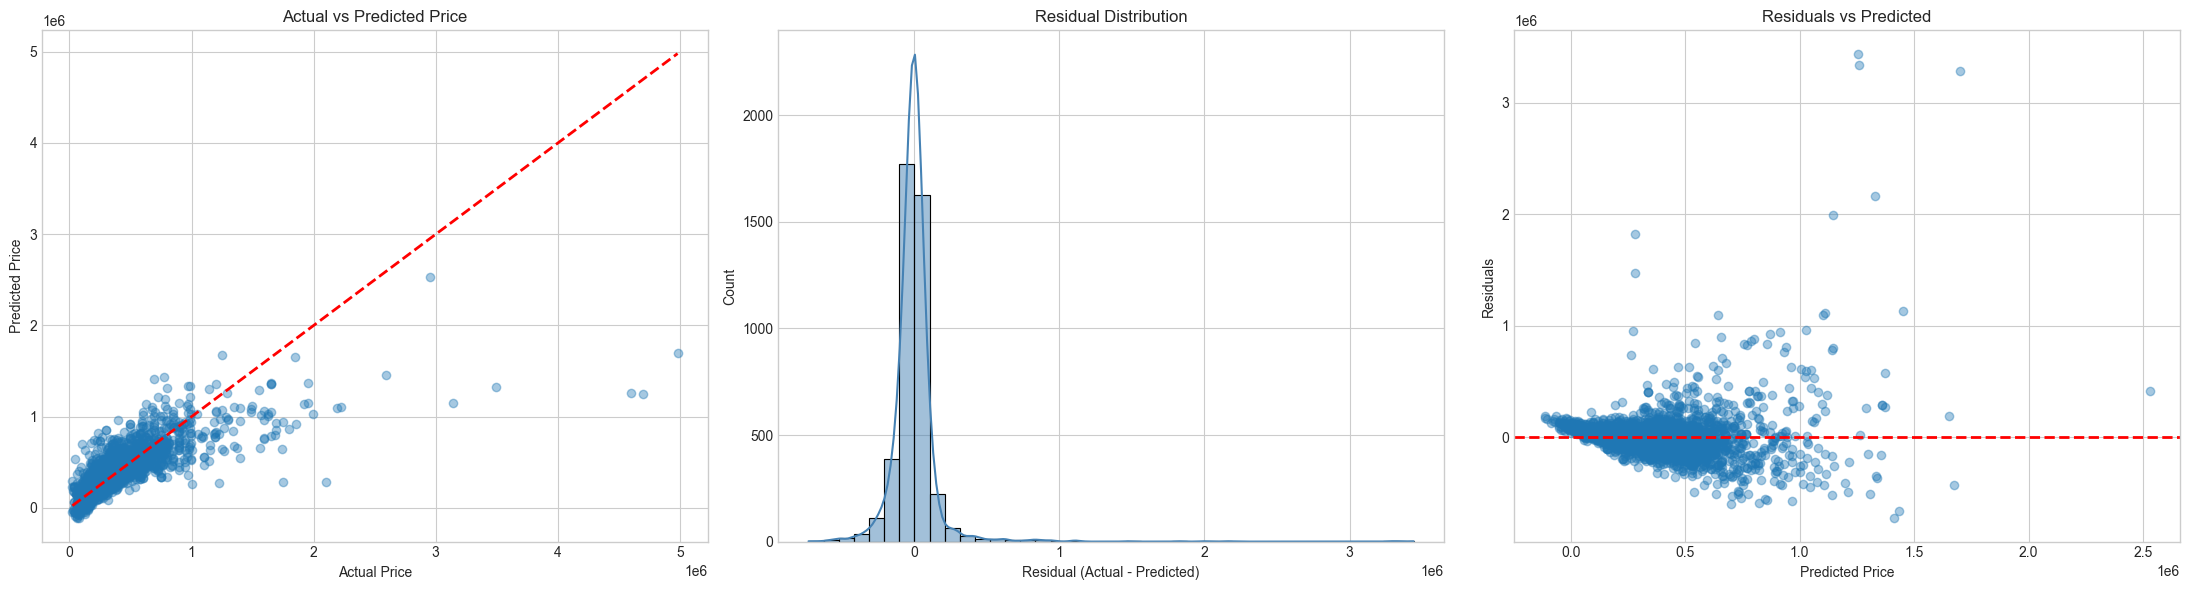

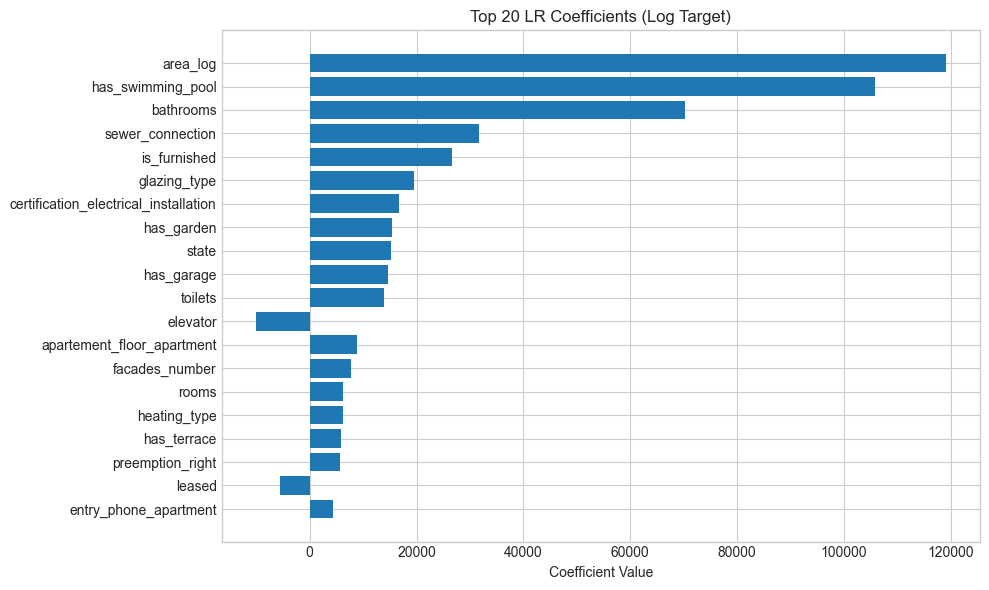

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1) Build dataset
df3 = prepare_stage3_dataset("../data/clean/clean_dataset_stage3_v4.csv")
X_lr, y_lr = prepare_X_y(df3, model_type="linear")

# 2) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_lr, y_lr, test_size=0.2, random_state=42
)

# 3) Train LR
lr = LinearRegression()
lr.fit(X_train, y_train)

# 4) Evaluate
y_pred = lr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Linear Regression")
print("MAE:", mae)
print("R²:", r2)


# -------------------------------------------------
#  VISUALIZATION BLOCK
# -------------------------------------------------

plt.style.use("seaborn-v0_8-whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# -------------------------------------------------
# Plot 1: Actual vs Predicted
# -------------------------------------------------
axes[0].scatter(y_test, y_pred, alpha=0.4)
axes[0].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', linewidth=2)
axes[0].set_title("Actual vs Predicted Price")
axes[0].set_xlabel("Actual Price")
axes[0].set_ylabel("Predicted Price")

# -------------------------------------------------
# Plot 2: Residual Distribution
# -------------------------------------------------
residuals = y_test - y_pred
sns.histplot(residuals, kde=True, ax=axes[1], bins=40, color="steelblue")
axes[1].set_title("Residual Distribution")
axes[1].set_xlabel("Residual (Actual - Predicted)")

# -------------------------------------------------
# Plot 3: Residuals vs Predicted
# -------------------------------------------------
axes[2].scatter(y_pred, residuals, alpha=0.4)
axes[2].axhline(0, color='red', linestyle='--', linewidth=2)
axes[2].set_title("Residuals vs Predicted")
axes[2].set_xlabel("Predicted Price")
axes[2].set_ylabel("Residuals")

plt.tight_layout()
plt.show()

# -------------------------------------------------
# Plot 3: Feature Importance for LR
# -------------------------------------------------
def plot_lr_feature_importance(model, X, top_n=20, title="LR Feature Importance"):
    import numpy as np
    import matplotlib.pyplot as plt

    coefs = model.coef_
    features = np.array(X.columns)

    idx = np.argsort(np.abs(coefs))[::-1][:top_n]
    top_features = features[idx]
    top_coefs = coefs[idx]

    plt.figure(figsize=(10, 6))
    y_pos = np.arange(len(top_features))
    plt.barh(y_pos, top_coefs)
    plt.yticks(y_pos, top_features)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Coefficient Value")
    plt.tight_layout()
    plt.show()

# Example usage:
plot_lr_feature_importance(lr, X_lr, top_n=20, title="Top 20 LR Coefficients (Log Target)")



Random Forrest n_estimators=200 

Random Forest Performance
MAE: 55002.59
R²: 0.7239


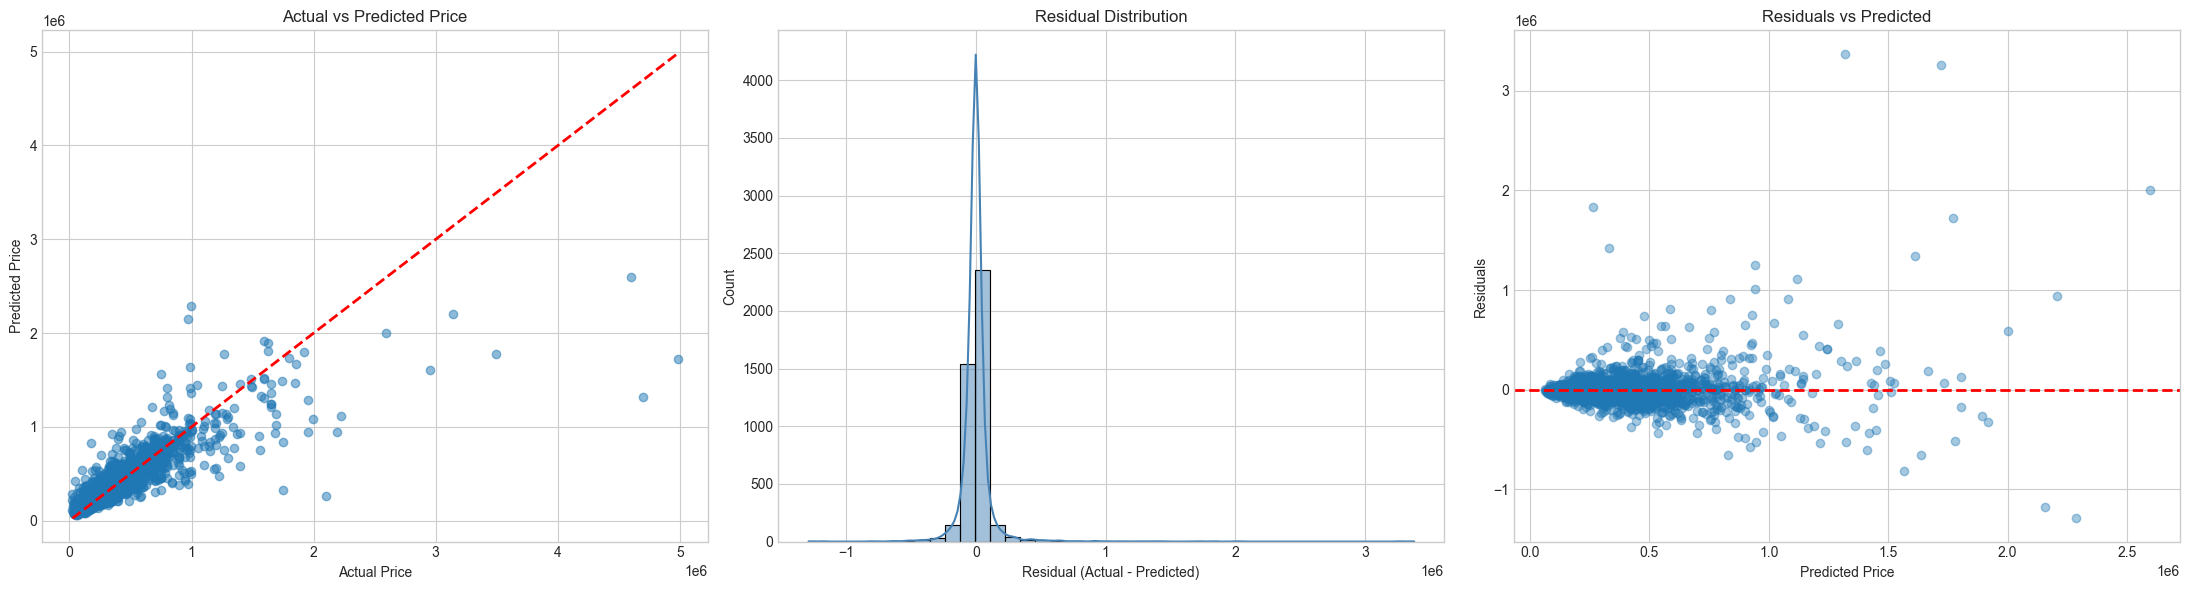

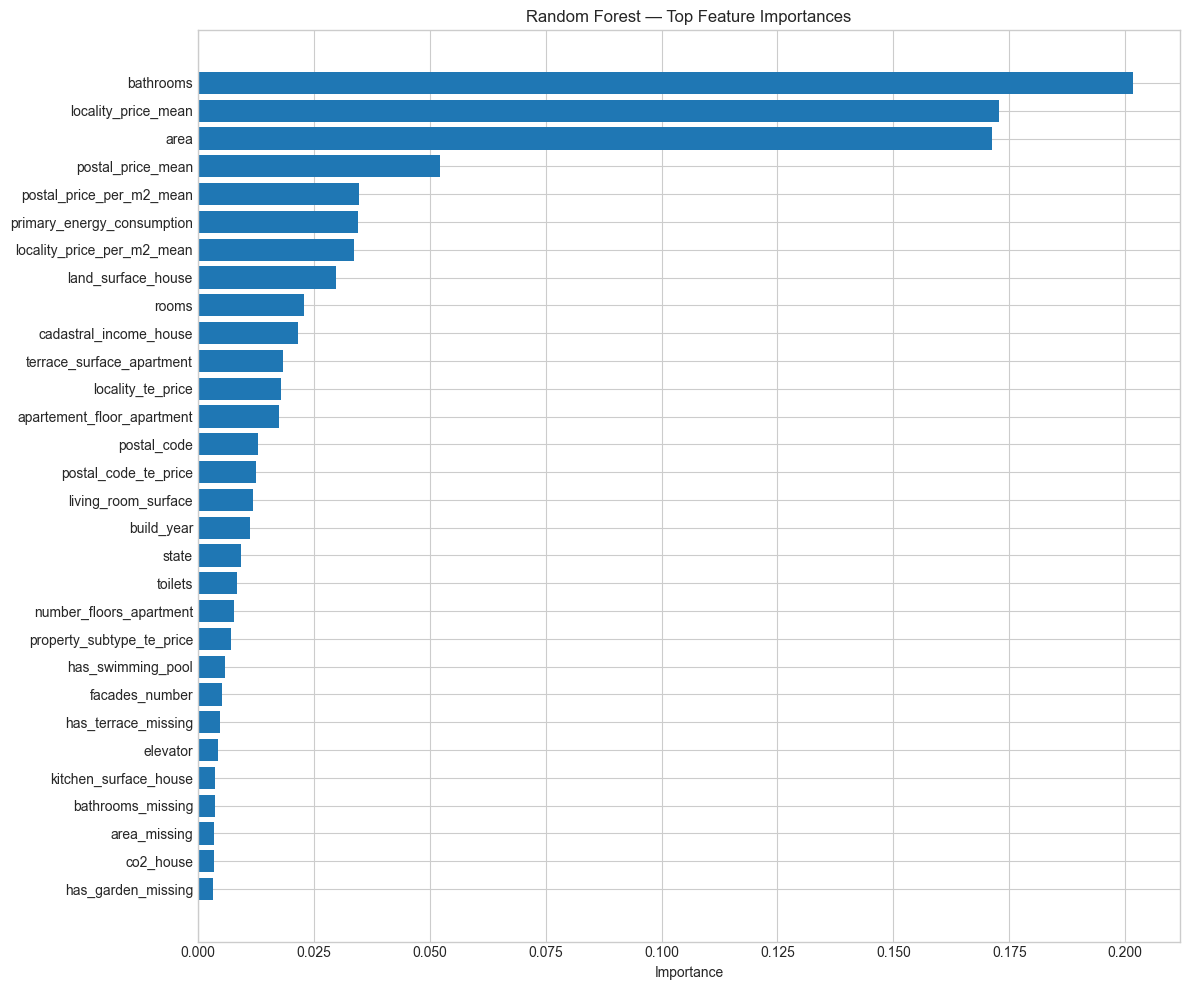

In [4]:
# ============================================================
# 0. Imports
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score


# ============================================================
# 1. Load & Prepare Data (Stage 3)
# ============================================================

df3 = pd.read_csv("../data/clean/clean_dataset_stage3_v4.csv")

# Build X and y for Random Forest (numeric-only + TE columns)
X_rf, y_rf = prepare_X_y(df3, model_type="rf")

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=42
)


# ============================================================
# 2. Train Random Forest
# ============================================================

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
)

rf.fit(X_train, y_train)


# ============================================================
# 3. Evaluate Model
# ============================================================

y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Random Forest Performance")
print("MAE:", round(mae, 2))
print("R²:", round(r2, 4))


# ============================================================
# 4. VISUALIZATION — Actual vs Predicted
# ============================================================

plt.style.use("seaborn-v0_8-whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# ----------------------------------
# Plot 1: Actual vs Predicted Price
# ----------------------------------
axes[0].scatter(y_test, y_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', linewidth=2)

axes[0].set_title("Actual vs Predicted Price")
axes[0].set_xlabel("Actual Price")
axes[0].set_ylabel("Predicted Price")


# ============================================================
# 5. VISUALIZATION — Residual Distribution
# ============================================================

residuals = y_test - y_pred

sns.histplot(residuals, bins=40, kde=True, ax=axes[1], color="steelblue")
axes[1].set_title("Residual Distribution")
axes[1].set_xlabel("Residual (Actual - Predicted)")


# ============================================================
# 6. VISUALIZATION — Residuals vs Predicted
# ============================================================

axes[2].scatter(y_pred, residuals, alpha=0.4)
axes[2].axhline(0, color='red', linestyle='--', linewidth=2)

axes[2].set_title("Residuals vs Predicted")
axes[2].set_xlabel("Predicted Price")
axes[2].set_ylabel("Residuals")

plt.tight_layout()
plt.show()


# ============================================================
# 7. FEATURE IMPORTANCE — Top 30
# ============================================================

def plot_tree_importances(model, X, top_n=30):
    importances = model.feature_importances_
    features = np.array(X.columns)

    # Sort by importance
    idx = np.argsort(importances)[::-1][:top_n]
    top_features = features[idx]
    top_importances = importances[idx]

    plt.figure(figsize=(12, 10))
    y_pos = np.arange(len(top_features))
    plt.barh(y_pos, top_importances)
    plt.yticks(y_pos, top_features)
    plt.gca().invert_yaxis()
    plt.title("Random Forest — Top Feature Importances")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

plot_tree_importances(rf, X_rf, top_n=30)


Random Forest Performance
MAE: 54923.62
R²: 0.7249


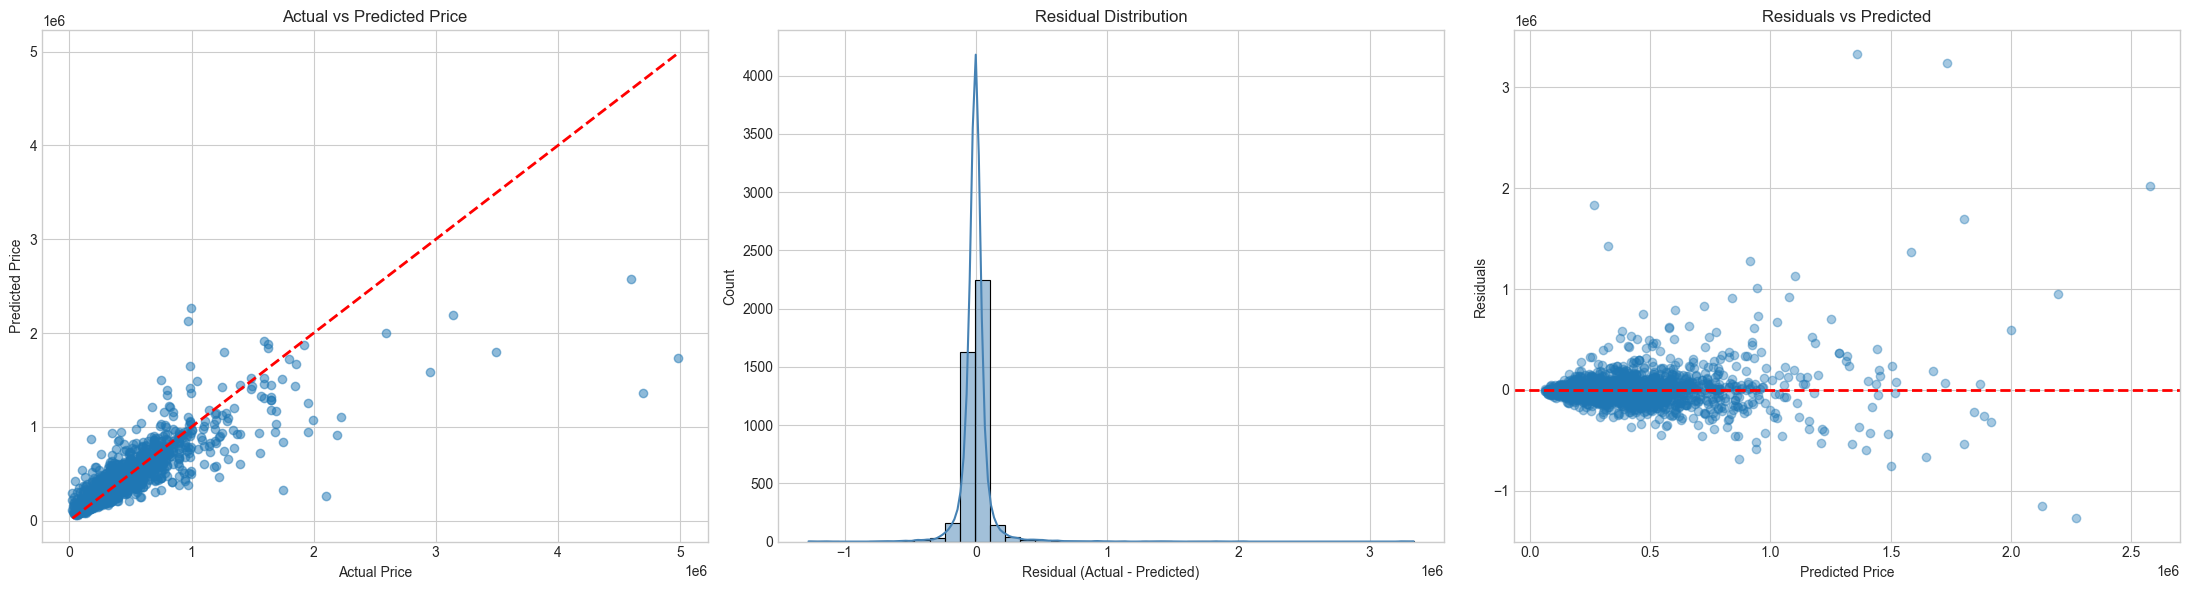

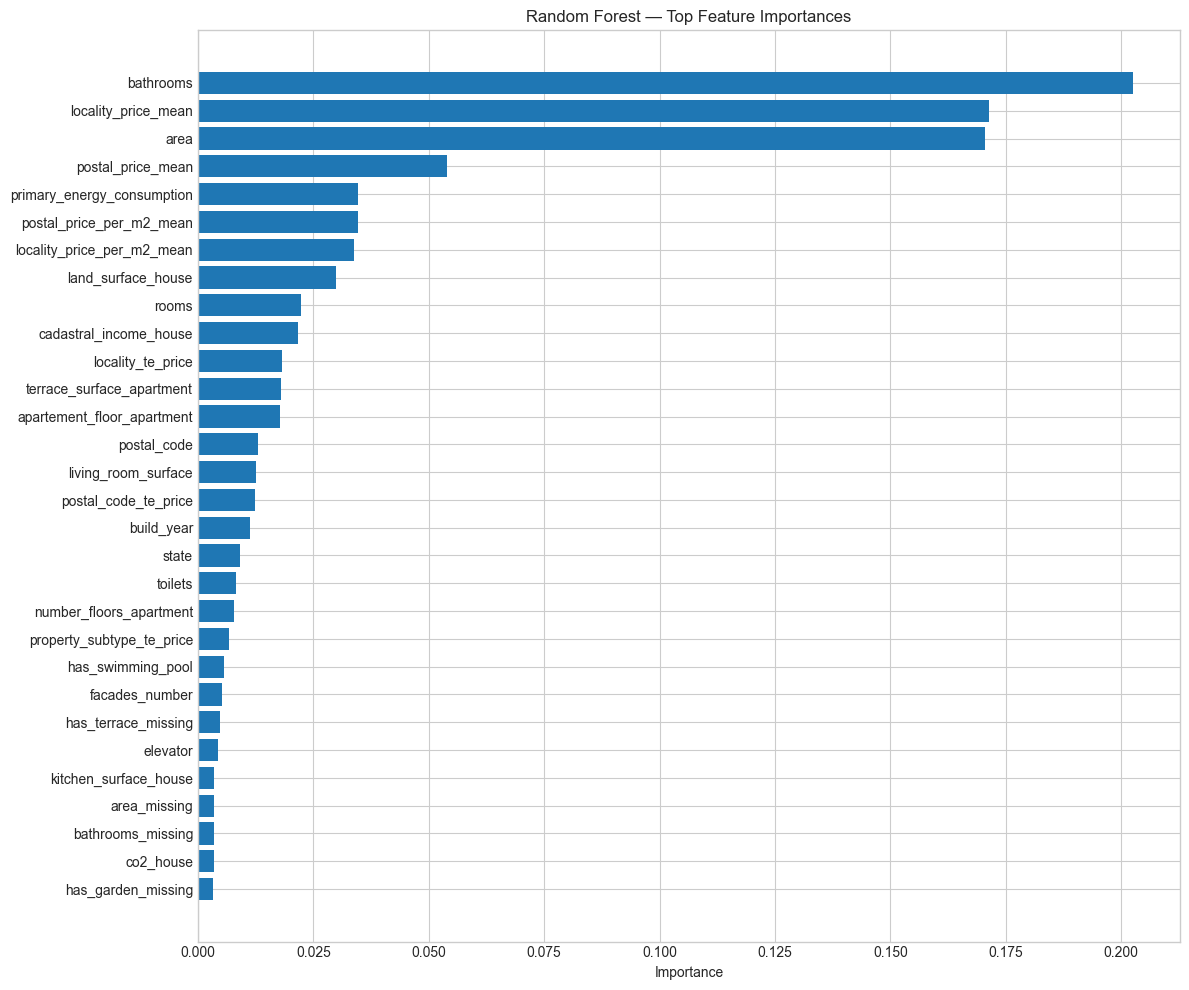

In [5]:
# ============================================================
# 0. Imports
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score


# ============================================================
# 1. Load & Prepare Data (Stage 3)
# ============================================================

df3 = pd.read_csv("../data/clean/clean_dataset_stage3_v4.csv")

# Build X and y for Random Forest (numeric-only + TE columns)
X_rf, y_rf = prepare_X_y(df3, model_type="rf")

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=42
)


# ============================================================
# 2. Train Random Forest
# ============================================================

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
)

rf.fit(X_train, y_train)


# ============================================================
# 3. Evaluate Model
# ============================================================

y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Random Forest Performance")
print("MAE:", round(mae, 2))
print("R²:", round(r2, 4))


# ============================================================
# 4. VISUALIZATION — Actual vs Predicted
# ============================================================

plt.style.use("seaborn-v0_8-whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# ----------------------------------
# Plot 1: Actual vs Predicted Price
# ----------------------------------
axes[0].scatter(y_test, y_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', linewidth=2)

axes[0].set_title("Actual vs Predicted Price")
axes[0].set_xlabel("Actual Price")
axes[0].set_ylabel("Predicted Price")


# ============================================================
# 5. VISUALIZATION — Residual Distribution
# ============================================================

residuals = y_test - y_pred

sns.histplot(residuals, bins=40, kde=True, ax=axes[1], color="steelblue")
axes[1].set_title("Residual Distribution")
axes[1].set_xlabel("Residual (Actual - Predicted)")


# ============================================================
# 6. VISUALIZATION — Residuals vs Predicted
# ============================================================

axes[2].scatter(y_pred, residuals, alpha=0.4)
axes[2].axhline(0, color='red', linestyle='--', linewidth=2)

axes[2].set_title("Residuals vs Predicted")
axes[2].set_xlabel("Predicted Price")
axes[2].set_ylabel("Residuals")

plt.tight_layout()
plt.show()


# ============================================================
# 7. FEATURE IMPORTANCE — Top 30
# ============================================================

def plot_tree_importances(model, X, top_n=30):
    importances = model.feature_importances_
    features = np.array(X.columns)

    # Sort by importance
    idx = np.argsort(importances)[::-1][:top_n]
    top_features = features[idx]
    top_importances = importances[idx]

    plt.figure(figsize=(12, 10))
    y_pos = np.arange(len(top_features))
    plt.barh(y_pos, top_importances)
    plt.yticks(y_pos, top_features)
    plt.gca().invert_yaxis()
    plt.title("Random Forest — Top Feature Importances")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

plot_tree_importances(rf, X_rf, top_n=30)


Random Forest Performance
MAE: 54775.54
R²: 0.7243


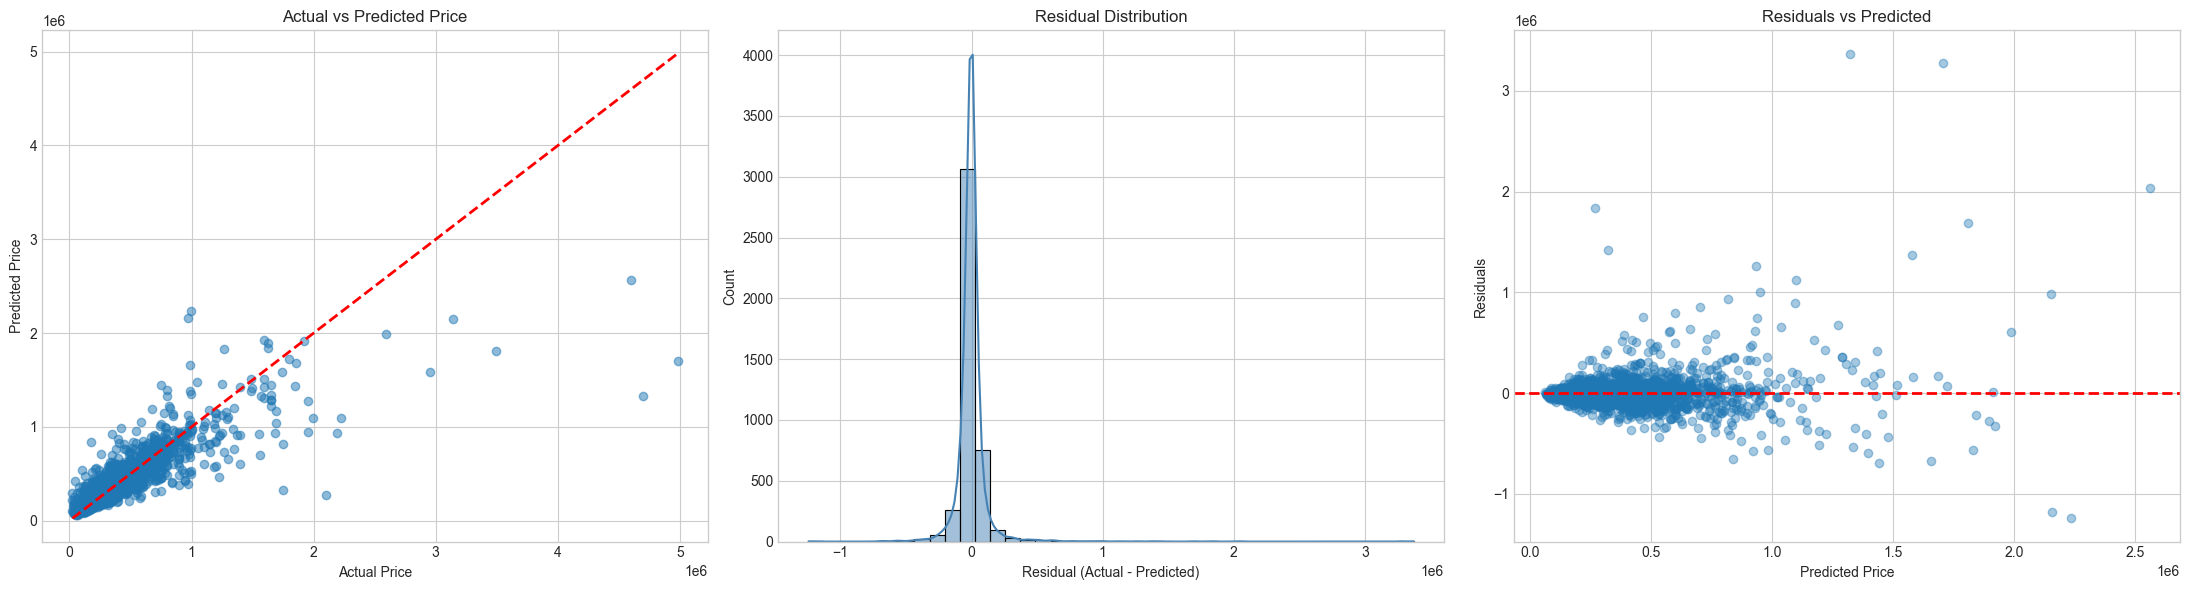

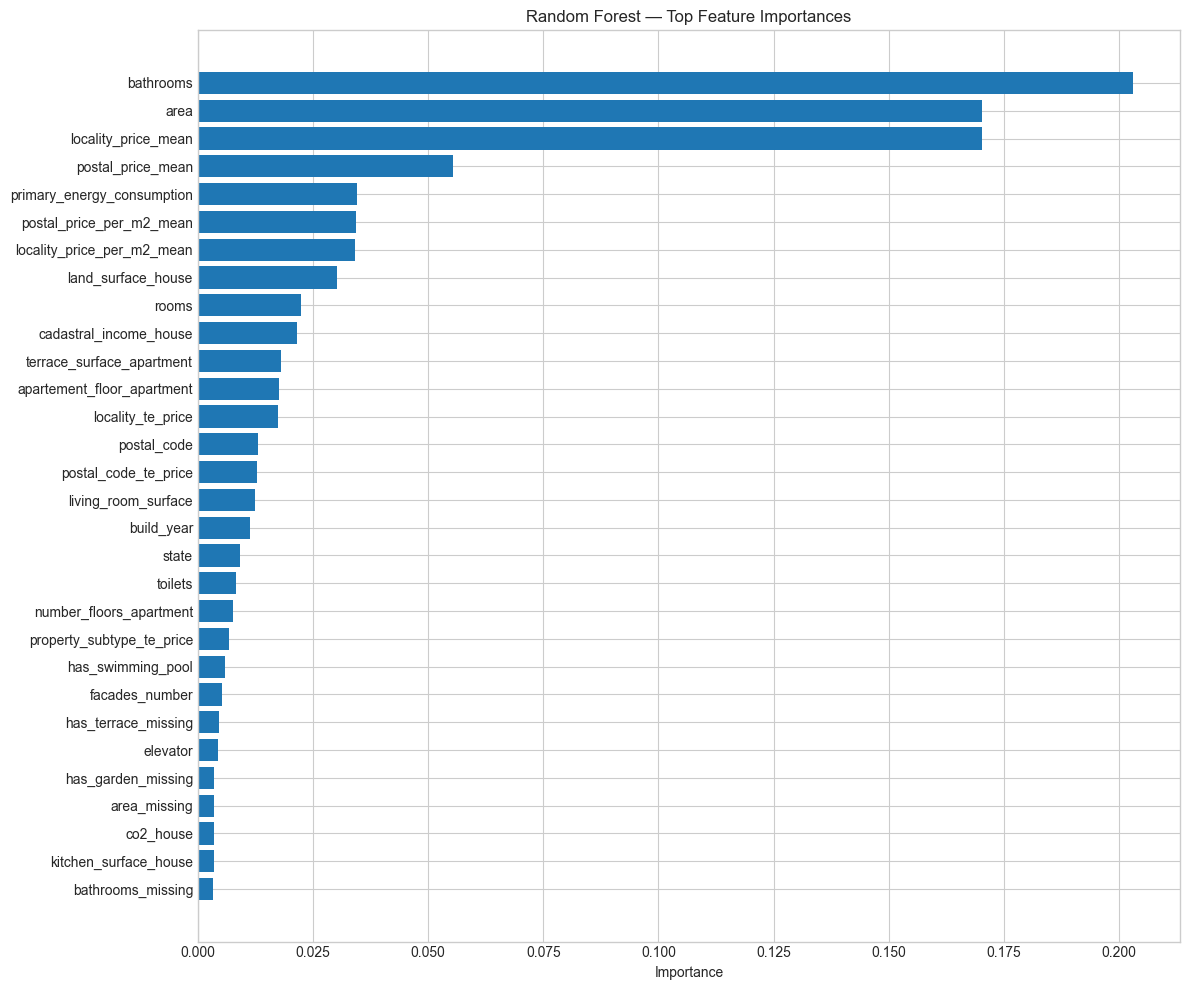

In [6]:
# ============================================================
# 0. Imports
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score


# ============================================================
# 1. Load & Prepare Data (Stage 3)
# ============================================================

df3 = pd.read_csv("../data/clean/clean_dataset_stage3_v4.csv")

# Build X and y for Random Forest (numeric-only + TE columns)
X_rf, y_rf = prepare_X_y(df3, model_type="rf")

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=42
)


# ============================================================
# 2. Train Random Forest
# ============================================================

rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
)

rf.fit(X_train, y_train)


# ============================================================
# 3. Evaluate Model
# ============================================================

y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Random Forest Performance")
print("MAE:", round(mae, 2))
print("R²:", round(r2, 4))


# ============================================================
# 4. VISUALIZATION — Actual vs Predicted
# ============================================================

plt.style.use("seaborn-v0_8-whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# ----------------------------------
# Plot 1: Actual vs Predicted Price
# ----------------------------------
axes[0].scatter(y_test, y_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', linewidth=2)

axes[0].set_title("Actual vs Predicted Price")
axes[0].set_xlabel("Actual Price")
axes[0].set_ylabel("Predicted Price")


# ============================================================
# 5. VISUALIZATION — Residual Distribution
# ============================================================

residuals = y_test - y_pred

sns.histplot(residuals, bins=40, kde=True, ax=axes[1], color="steelblue")
axes[1].set_title("Residual Distribution")
axes[1].set_xlabel("Residual (Actual - Predicted)")


# ============================================================
# 6. VISUALIZATION — Residuals vs Predicted
# ============================================================

axes[2].scatter(y_pred, residuals, alpha=0.4)
axes[2].axhline(0, color='red', linestyle='--', linewidth=2)

axes[2].set_title("Residuals vs Predicted")
axes[2].set_xlabel("Predicted Price")
axes[2].set_ylabel("Residuals")

plt.tight_layout()
plt.show()


# ============================================================
# 7. FEATURE IMPORTANCE — Top 30
# ============================================================

def plot_tree_importances(model, X, top_n=30):
    importances = model.feature_importances_
    features = np.array(X.columns)

    # Sort by importance
    idx = np.argsort(importances)[::-1][:top_n]
    top_features = features[idx]
    top_importances = importances[idx]

    plt.figure(figsize=(12, 10))
    y_pos = np.arange(len(top_features))
    plt.barh(y_pos, top_importances)
    plt.yticks(y_pos, top_features)
    plt.gca().invert_yaxis()
    plt.title("Random Forest — Top Feature Importances")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

plot_tree_importances(rf, X_rf, top_n=30)


In [7]:
# ============================================================
# EXTRA: Train Predictions & Full Metrics
# ============================================================

# Train predictions
y_train_pred = rf.predict(X_train)

# Train metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Test metrics (already computed above)
test_mae = mae
test_r2 = r2

print("\n================ RANDOM FOREST METRICS ================\n")
print(">>> TRAIN SET")
print(f"MAE (train): {train_mae:,.2f}")
print(f"R² (train):  {train_r2:.4f}")

print("\n>>> TEST SET")
print(f"MAE (test):  {test_mae:,.2f}")
print(f"R² (test):   {test_r2:.4f}")
print("\n========================================================")



================ RANDOM FOREST METRICS ================

>>> TRAIN SET
MAE (train): 19,205.61
R² (train):  0.9670

>>> TEST SET
MAE (test):  54,775.54
R² (test):   0.7243



In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))  # add project root

import pandas as pd
pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score

from pipelines.pipeline_runner import run_full_pipeline_with_split  
from utils.ml_utils import prepare_X_y  

plt.style.use("seaborn-v0_8-whitegrid")


In [2]:
# Run leakage-safe pipeline with Stage0 → Stage1 → Stage2 → split → Stage3Fitter
dfs = run_full_pipeline_with_split()

df_raw    = dfs["raw"]
df_stage1 = dfs["stage1"]
df_stage2 = dfs["stage2"]

df_train = dfs["train"]
df_val   = dfs["val"]
df_test  = dfs["test"]

print("Shapes:")
print("raw      :", df_raw.shape)
print("stage1   :", df_stage1.shape)
print("stage2   :", df_stage2.shape)
print("train S3 :", df_train.shape)
print("val S3   :", df_val.shape)
print("test S3  :", df_test.shape)

# Optional: save train/val/test Stage 3 datasets
df_train.to_csv("../data/clean/train_stage3.csv", index=False)
df_val.to_csv("../data/clean/val_stage3.csv", index=False)
df_test.to_csv("../data/clean/test_stage3.csv", index=False)


Shapes:
raw      : (22306, 67)
stage1   : (22306, 72)
stage2   : (21647, 45)
train S3 : (15152, 79)
val S3   : (3247, 79)
test S3  : (3248, 79)


In [22]:
df_stage2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21647 entries, 0 to 23946
Data columns (total 44 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   url                                    21647 non-null  string 
 1   property_id                            21647 non-null  string 
 2   price                                  21647 non-null  float64
 3   rooms                                  21647 non-null  float64
 4   area                                   21647 non-null  float64
 5   state                                  21647 non-null  int64  
 6   facades_number                         21647 non-null  float64
 7   is_furnished                           21647 non-null  int64  
 8   has_terrace                            21647 non-null  int64  
 9   has_garden                             21647 non-null  int64  
 10  has_swimming_pool                      21647 non-null  int64  
 11  has_equ

In [24]:
df_stage2[["url"]].to_csv('../data/clean/urls_stage2.csv', index=False)

In [3]:
def evaluate_regression(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    print(f"===== {name} =====")
    print(f"MAE: {mae:,.2f}")
    print(f"R² : {r2:.4f}")
    return mae, r2


def plot_regression_diagnostics(y_true, y_pred, title_prefix="Model"):
    residuals = y_true - y_pred

    fig, axes = plt.subplots(1, 3, figsize=(22, 6))

    # 1) Actual vs Predicted
    axes[0].scatter(y_true, y_pred, alpha=0.4)
    min_v = min(y_true.min(), y_pred.min())
    max_v = max(y_true.max(), y_pred.max())
    axes[0].plot([min_v, max_v], [min_v, max_v], "r--", linewidth=2)
    axes[0].set_title(f"{title_prefix} — Actual vs Predicted")
    axes[0].set_xlabel("Actual Price")
    axes[0].set_ylabel("Predicted Price")

    # 2) Residual Distribution
    sns.histplot(residuals, kde=True, bins=40, ax=axes[1], color="steelblue")
    axes[1].set_title(f"{title_prefix} — Residual Distribution")
    axes[1].set_xlabel("Residual (Actual - Predicted)")

    # 3) Residuals vs Predicted
    axes[2].scatter(y_pred, residuals, alpha=0.4)
    axes[2].axhline(0, color="red", linestyle="--", linewidth=2)
    axes[2].set_title(f"{title_prefix} — Residuals vs Predicted")
    axes[2].set_xlabel("Predicted Price")
    axes[2].set_ylabel("Residual")

    plt.tight_layout()
    plt.show()


def plot_lr_feature_importance(model, feature_names, top_n=20, title="LR Coefficients"):
    """
    model: fitted LinearRegression (from pipeline.named_steps["model"])
    feature_names: list/Index of feature names (X.columns)
    """
    coefs = model.coef_
    features = np.array(feature_names)

    idx = np.argsort(np.abs(coefs))[::-1][:top_n]
    top_features = features[idx]
    top_coefs = coefs[idx]

    plt.figure(figsize=(10, 6))
    y_pos = np.arange(len(top_features))
    plt.barh(y_pos, top_coefs)
    plt.yticks(y_pos, top_features)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Coefficient value")
    plt.tight_layout()
    plt.show()


def plot_tree_importances(model, feature_names, top_n=30, title="Random Forest — Feature Importances"):
    importances = model.feature_importances_
    features = np.array(feature_names)
    idx = np.argsort(importances)[::-1][:top_n]
    top_features = features[idx]
    top_importances = importances[idx]

    plt.figure(figsize=(12, 10))
    y_pos = np.arange(len(top_features))
    plt.barh(y_pos, top_importances)
    plt.yticks(y_pos, top_features)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()


Shapes (LR):
X_train: (15152, 65)  y_train: (15152,)
X_val  : (3247, 65)  y_val  : (3247,)
X_test : (3248, 65)  y_test : (3248,)

NaNs in X_train (before imputer): 0

--- Linear Regression (Train) ---
===== LR — Train =====
MAE: 76,654.19
R² : 0.6717

--- Linear Regression (Validation) ---
===== LR — Validation =====
MAE: 85,621.02
R² : 0.5834

--- Linear Regression (Test) ---
===== LR — Test =====
MAE: 80,038.77
R² : 0.5590


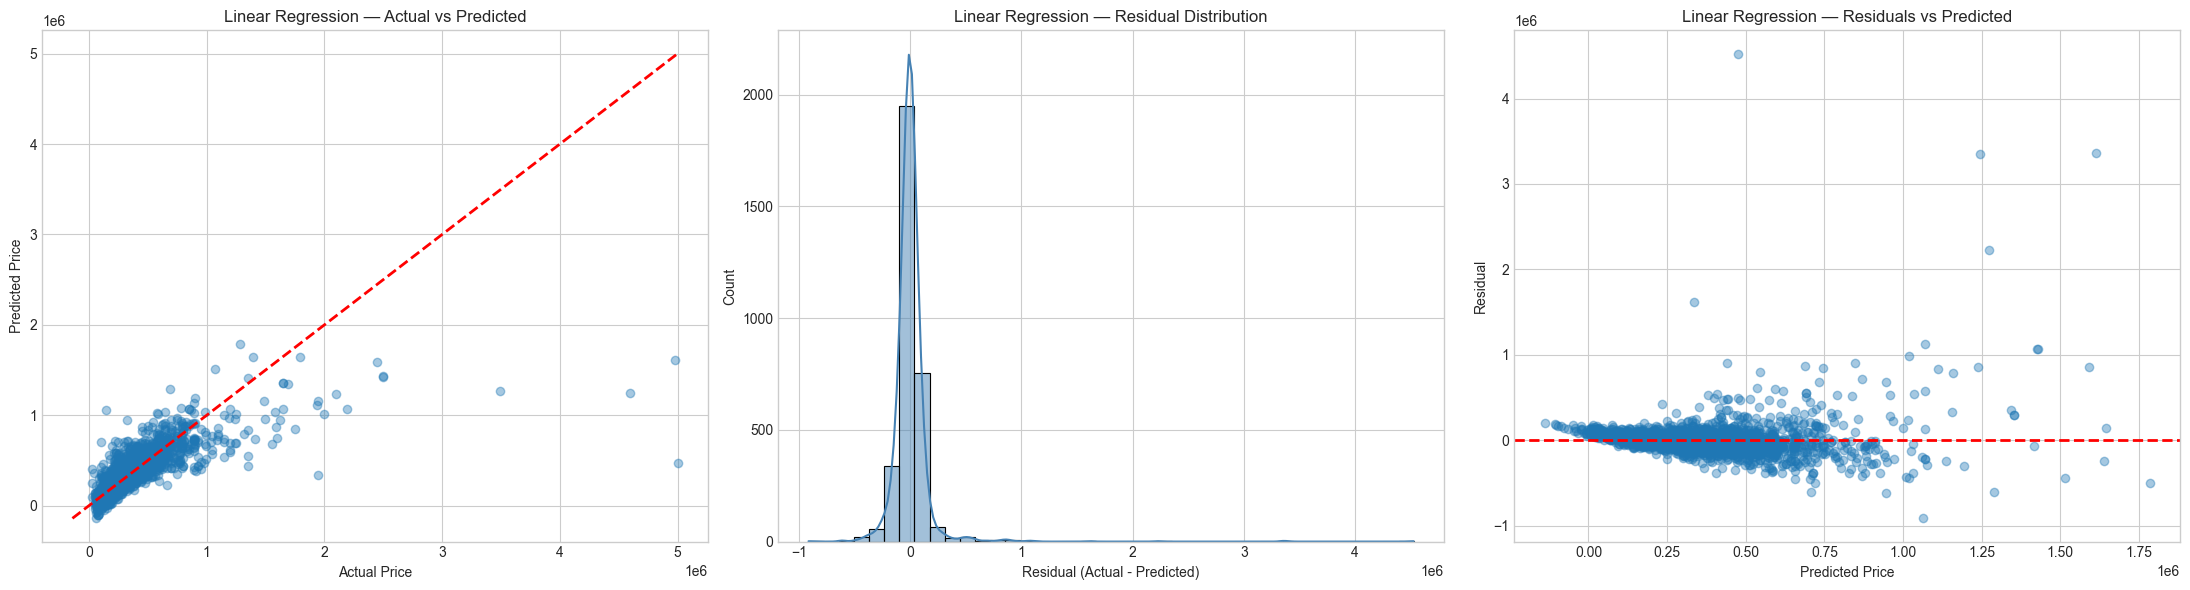

In [4]:
# ============================================================
# LINEAR REGRESSION — TRAIN / VAL / TEST
# ============================================================

# Build X, y from Stage 3 outputs
X_train_lr, y_train_lr = prepare_X_y(df_train, model_type="linear")
X_val_lr,   y_val_lr   = prepare_X_y(df_val,   model_type="linear")
X_test_lr,  y_test_lr  = prepare_X_y(df_test,  model_type="linear")

print("Shapes (LR):")
print("X_train:", X_train_lr.shape, " y_train:", y_train_lr.shape)
print("X_val  :", X_val_lr.shape,   " y_val  :", y_val_lr.shape)
print("X_test :", X_test_lr.shape,  " y_test :", y_test_lr.shape)

print("\nNaNs in X_train (before imputer):", int(X_train_lr.isna().sum().sum()))

# Pipeline: Impute (median) + Linear Regression
lr_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", LinearRegression())
    ]
)

# Fit on TRAIN only
lr_pipeline.fit(X_train_lr, y_train_lr)

# Evaluate on TRAIN, VAL, TEST
y_pred_train_lr = lr_pipeline.predict(X_train_lr)
y_pred_val_lr   = lr_pipeline.predict(X_val_lr)
y_pred_test_lr  = lr_pipeline.predict(X_test_lr)

print("\n--- Linear Regression (Train) ---")
evaluate_regression("LR — Train", y_train_lr, y_pred_train_lr)

print("\n--- Linear Regression (Validation) ---")
evaluate_regression("LR — Validation", y_val_lr, y_pred_val_lr)

print("\n--- Linear Regression (Test) ---")
evaluate_regression("LR — Test", y_test_lr, y_pred_test_lr)

# Diagnostics plots on TEST
plot_regression_diagnostics(y_test_lr, y_pred_test_lr, title_prefix="Linear Regression")


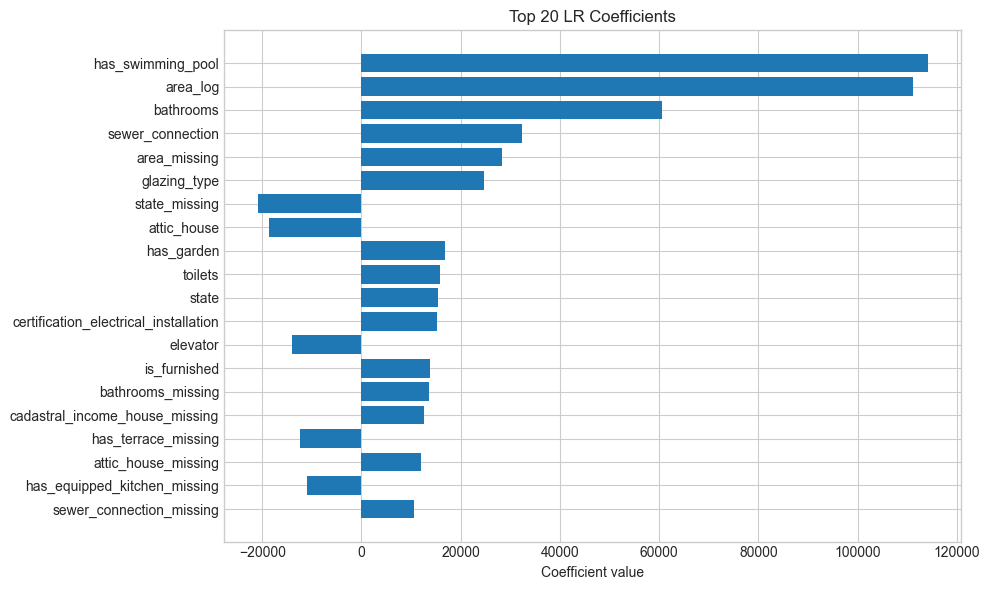

In [5]:
# ============================================================
# LR FEATURE IMPORTANCE (using coefficients)
# ============================================================

lr_model = lr_pipeline.named_steps["model"]
plot_lr_feature_importance(
    lr_model,
    X_train_lr.columns,
    top_n=20,
    title="Top 20 LR Coefficients"
)


Shapes (RF):
X_train: (15152, 68)  y_train: (15152,)
X_val  : (3247, 68)  y_val  : (3247,)
X_test : (3248, 68)  y_test : (3248,)

NaNs in X_train (before imputer): 0

--- Random Forest (Train) ---
===== RF — Train =====
MAE: 19,288.83
R² : 0.9687

--- Random Forest (Validation) ---
===== RF — Validation =====
MAE: 59,004.03
R² : 0.7216

--- Random Forest (Test) ---
===== RF — Test =====
MAE: 57,775.99
R² : 0.6340


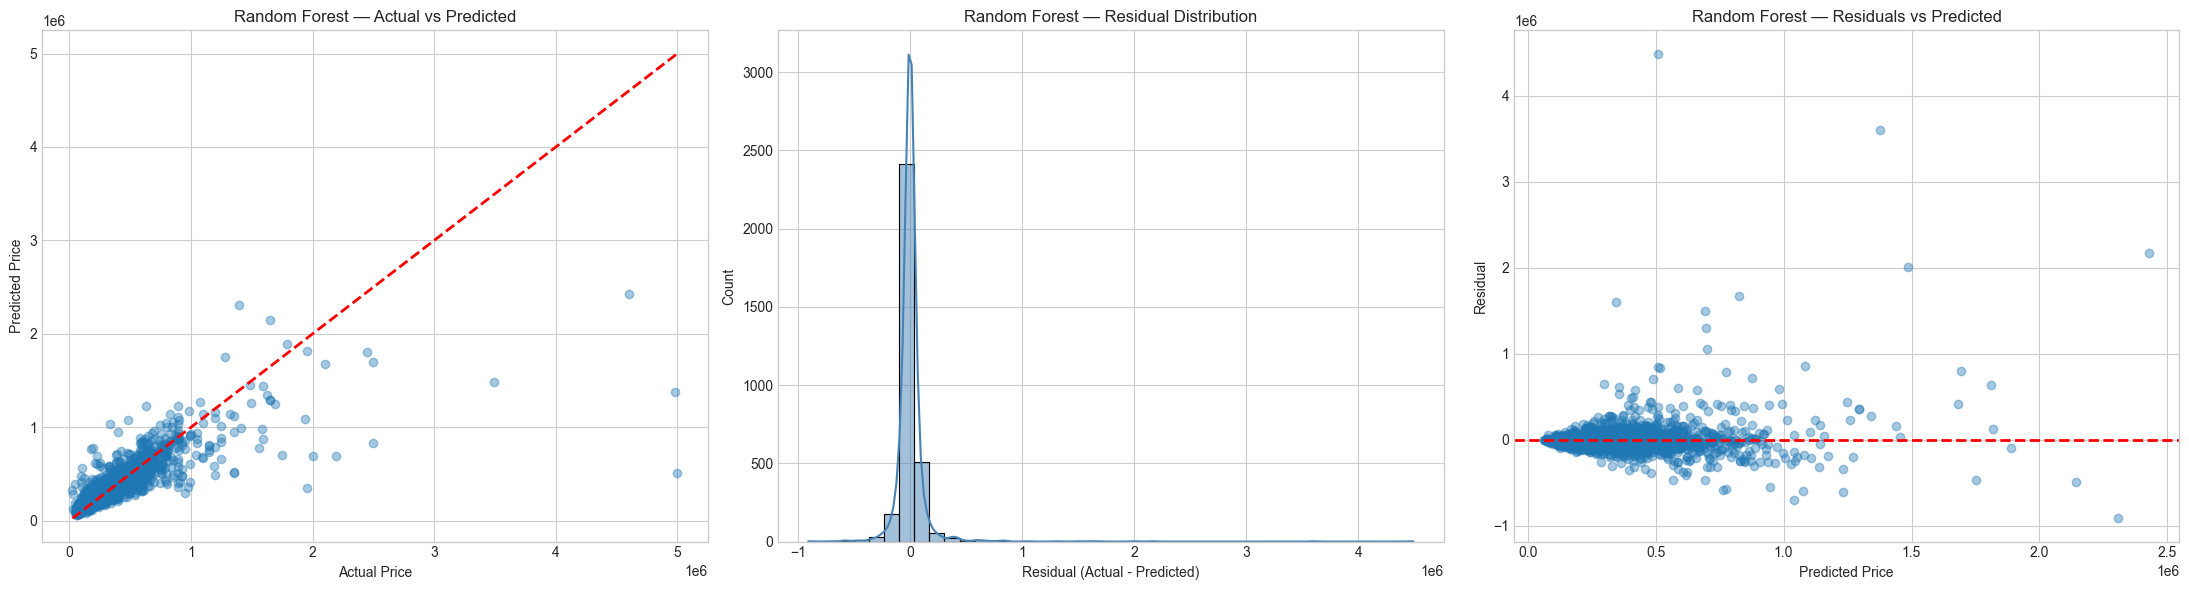

In [5]:
# ============================================================
# RANDOM FOREST — TRAIN / VAL / TEST
# ============================================================

X_train_rf, y_train_rf = prepare_X_y(df_train, model_type="rf")
X_val_rf,   y_val_rf   = prepare_X_y(df_val,   model_type="rf")
X_test_rf,  y_test_rf  = prepare_X_y(df_test,  model_type="rf")

print("Shapes (RF):")
print("X_train:", X_train_rf.shape, " y_train:", y_train_rf.shape)
print("X_val  :", X_val_rf.shape,   " y_val  :", y_val_rf.shape)
print("X_test :", X_test_rf.shape,  " y_test :", y_test_rf.shape)

print("\nNaNs in X_train (before imputer):", int(X_train_rf.isna().sum().sum()))

# Pipeline: Impute (median) + RandomForest
rf_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", RandomForestRegressor(
            n_estimators=300,
            random_state=42,
            n_jobs=-1
        ))
    ]
)

# Fit on TRAIN
rf_pipeline.fit(X_train_rf, y_train_rf)

# Predict
y_pred_train_rf = rf_pipeline.predict(X_train_rf)
y_pred_val_rf   = rf_pipeline.predict(X_val_rf)
y_pred_test_rf  = rf_pipeline.predict(X_test_rf)

print("\n--- Random Forest (Train) ---")
evaluate_regression("RF — Train", y_train_rf, y_pred_train_rf)

print("\n--- Random Forest (Validation) ---")
evaluate_regression("RF — Validation", y_val_rf, y_pred_val_rf)

print("\n--- Random Forest (Test) ---")
evaluate_regression("RF — Test", y_test_rf, y_pred_test_rf)

# Diagnostics on TEST
plot_regression_diagnostics(y_test_rf, y_pred_test_rf, title_prefix="Random Forest")


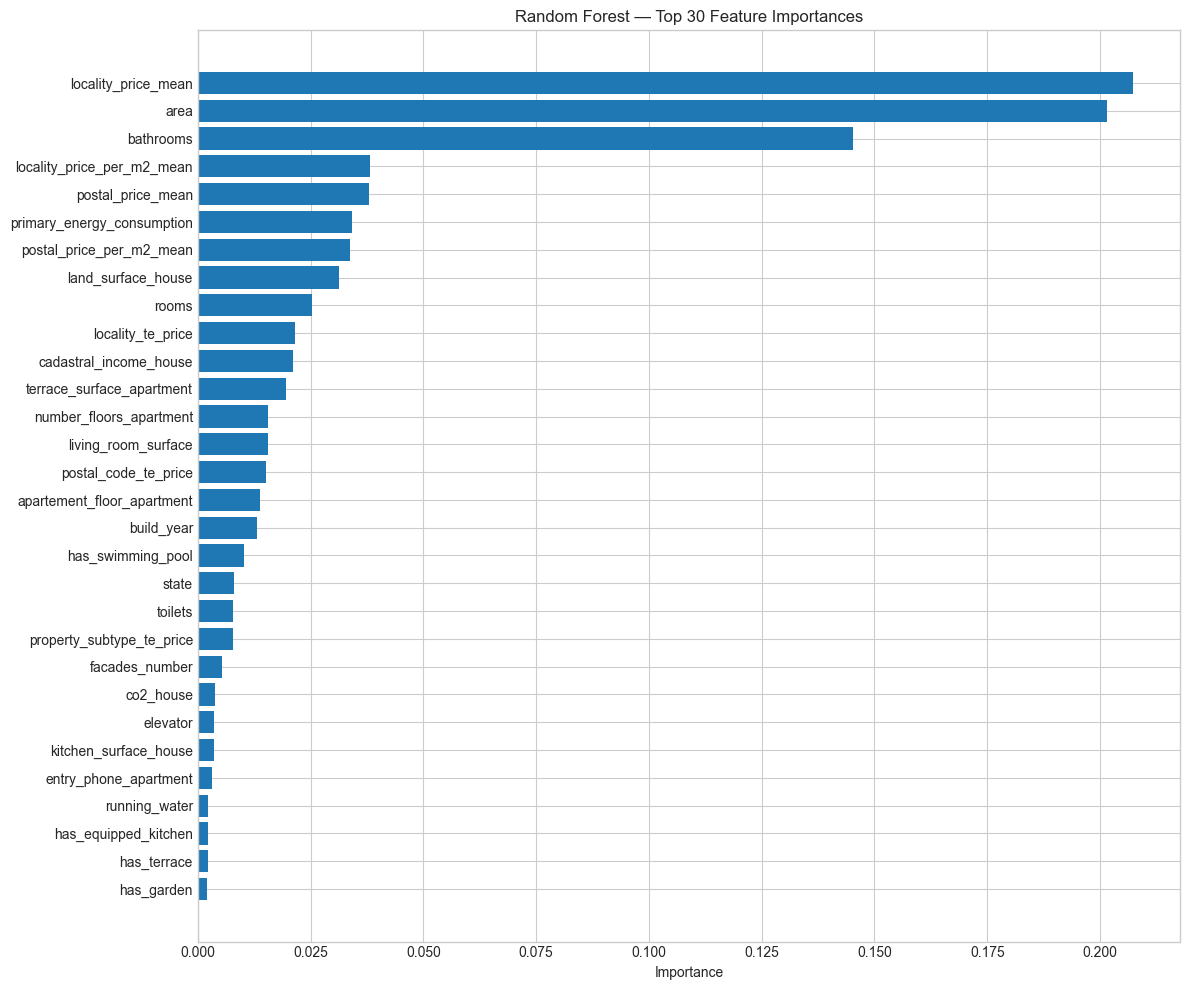

In [7]:
# ============================================================
# RF FEATURE IMPORTANCE
# ============================================================

rf_model = rf_pipeline.named_steps["model"]

plot_tree_importances(
    rf_model,
    X_train_rf.columns,
    top_n=30,
    title="Random Forest — Top 30 Feature Importances"
)


Shapes (Decision Tree):
X_train: (15152, 68)  y_train: (15152,)
X_val  : (3247, 68)  y_val  : (3247,)
X_test : (3248, 68)  y_test : (3248,)

--- Decision Tree (Train) ---
===== Decision Tree — Train =====
MAE: 296.12
R² : 0.9998

--- Decision Tree (Validation) ---
===== Decision Tree — Validation =====
MAE: 74,218.27
R² : 0.5295

--- Decision Tree (Test) ---
===== Decision Tree — Test =====
MAE: 86,516.37
R² : 0.4740


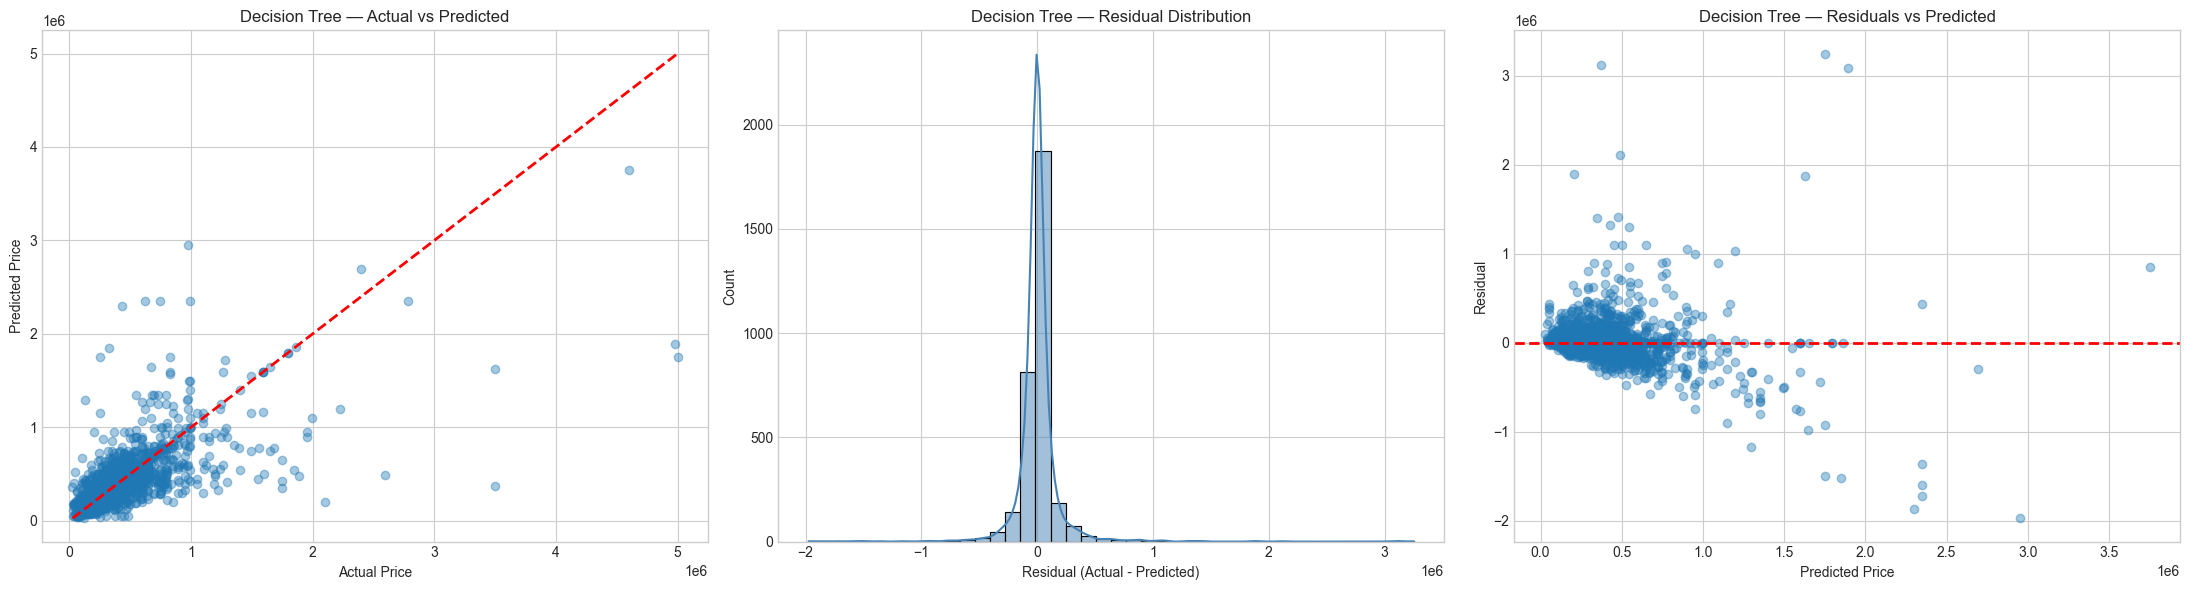

In [8]:
# ============================================================
# DECISION TREE REGRESSOR — TRAIN / VAL / TEST
# ============================================================

from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Build X, y
X_train_dt, y_train_dt = prepare_X_y(df_train, model_type="rf")
X_val_dt,   y_val_dt   = prepare_X_y(df_val,   model_type="rf")
X_test_dt,  y_test_dt  = prepare_X_y(df_test,  model_type="rf")

print("Shapes (Decision Tree):")
print("X_train:", X_train_dt.shape, " y_train:", y_train_dt.shape)
print("X_val  :", X_val_dt.shape,   " y_val  :", y_val_dt.shape)
print("X_test :", X_test_dt.shape,  " y_test :", y_test_dt.shape)

# Pipeline: Impute + Decision Tree
dt_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", DecisionTreeRegressor(
            max_depth=None,
            min_samples_split=2,
            random_state=42
        ))
    ]
)

# Fit
dt_pipeline.fit(X_train_dt, y_train_dt)

# Predict
y_pred_train_dt = dt_pipeline.predict(X_train_dt)
y_pred_val_dt   = dt_pipeline.predict(X_val_dt)
y_pred_test_dt  = dt_pipeline.predict(X_test_dt)

# Evaluate
print("\n--- Decision Tree (Train) ---")
evaluate_regression("Decision Tree — Train", y_train_dt, y_pred_train_dt)

print("\n--- Decision Tree (Validation) ---")
evaluate_regression("Decision Tree — Validation", y_val_dt, y_pred_val_dt)

print("\n--- Decision Tree (Test) ---")
evaluate_regression("Decision Tree — Test", y_test_dt, y_pred_test_dt)

# Diagnostics plots on TEST
plot_regression_diagnostics(y_test_dt, y_pred_test_dt, title_prefix="Decision Tree")


Shapes (SVR):
X_train: (15152, 65)  y_train: (15152,)
X_val  : (3247, 65)  y_val  : (3247,)
X_test : (3248, 65)  y_test : (3248,)

--- SVR (Train) ---
===== SVR — Train =====
MAE: 138,667.91
R² : -0.0389

--- SVR (Validation) ---
===== SVR — Validation =====
MAE: 138,406.96
R² : -0.0333

--- SVR (Test) ---
===== SVR — Test =====
MAE: 149,432.51
R² : -0.0474


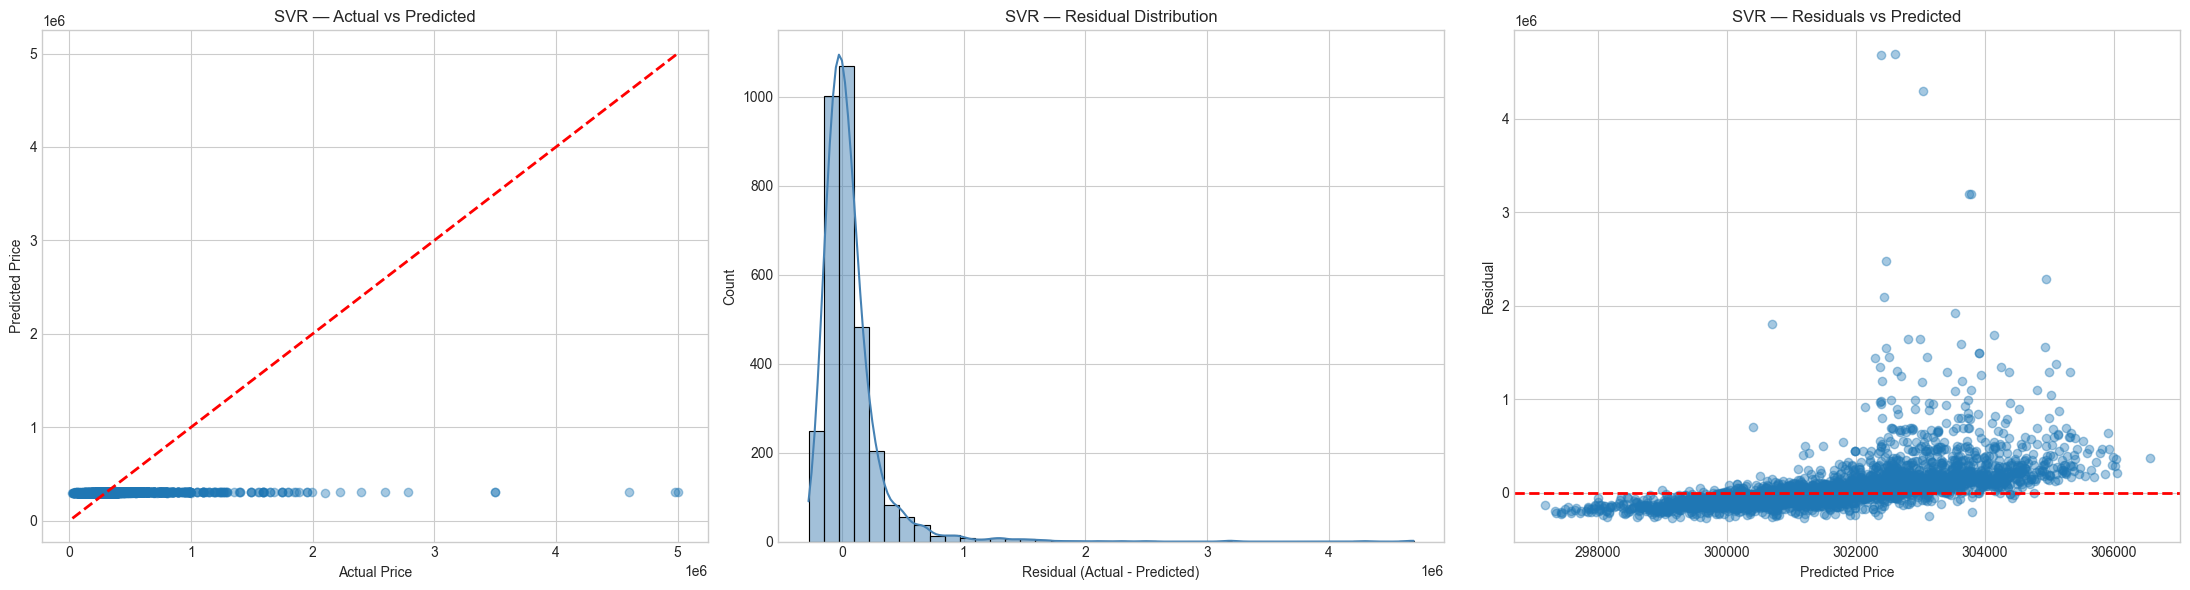

In [9]:
# ============================================================
# SUPPORT VECTOR REGRESSION (SVR) — TRAIN / VAL / TEST
# ============================================================

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Build X, y
X_train_svr, y_train_svr = prepare_X_y(df_train, model_type="linear")  # numeric only
X_val_svr,   y_val_svr   = prepare_X_y(df_val,   model_type="linear")
X_test_svr,  y_test_svr  = prepare_X_y(df_test,  model_type="linear")

print("Shapes (SVR):")
print("X_train:", X_train_svr.shape, " y_train:", y_train_svr.shape)
print("X_val  :", X_val_svr.shape,   " y_val  :", y_val_svr.shape)
print("X_test :", X_test_svr.shape,  " y_test :", y_test_svr.shape)

# Pipeline: Imputer + Scaler + SVR
svr_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", SVR(
            kernel="rbf",
            C=10,
            epsilon=0.1
        ))
    ]
)

# Fit
svr_pipeline.fit(X_train_svr, y_train_svr)

# Predict
y_pred_train_svr = svr_pipeline.predict(X_train_svr)
y_pred_val_svr   = svr_pipeline.predict(X_val_svr)
y_pred_test_svr  = svr_pipeline.predict(X_test_svr)

# Evaluate
print("\n--- SVR (Train) ---")
evaluate_regression("SVR — Train", y_train_svr, y_pred_train_svr)

print("\n--- SVR (Validation) ---")
evaluate_regression("SVR — Validation", y_val_svr, y_pred_val_svr)

print("\n--- SVR (Test) ---")
evaluate_regression("SVR — Test", y_test_svr, y_pred_test_svr)

# Diagnostics on TEST
plot_regression_diagnostics(y_test_svr, y_pred_test_svr, title_prefix="SVR")


Shapes (XGBoost):
X_train: (15152, 68)  y_train: (15152,)
X_val  : (3247, 68)  y_val  : (3247,)
X_test : (3248, 68)  y_test : (3248,)

--- XGBoost (Train) ---
===== XGBoost — Train =====
MAE: 19,560.89
R² : 0.9862

--- XGBoost (Validation) ---
===== XGBoost — Validation =====
MAE: 55,541.94
R² : 0.7589

--- XGBoost (Test) ---
===== XGBoost — Test =====
MAE: 54,886.60
R² : 0.6678


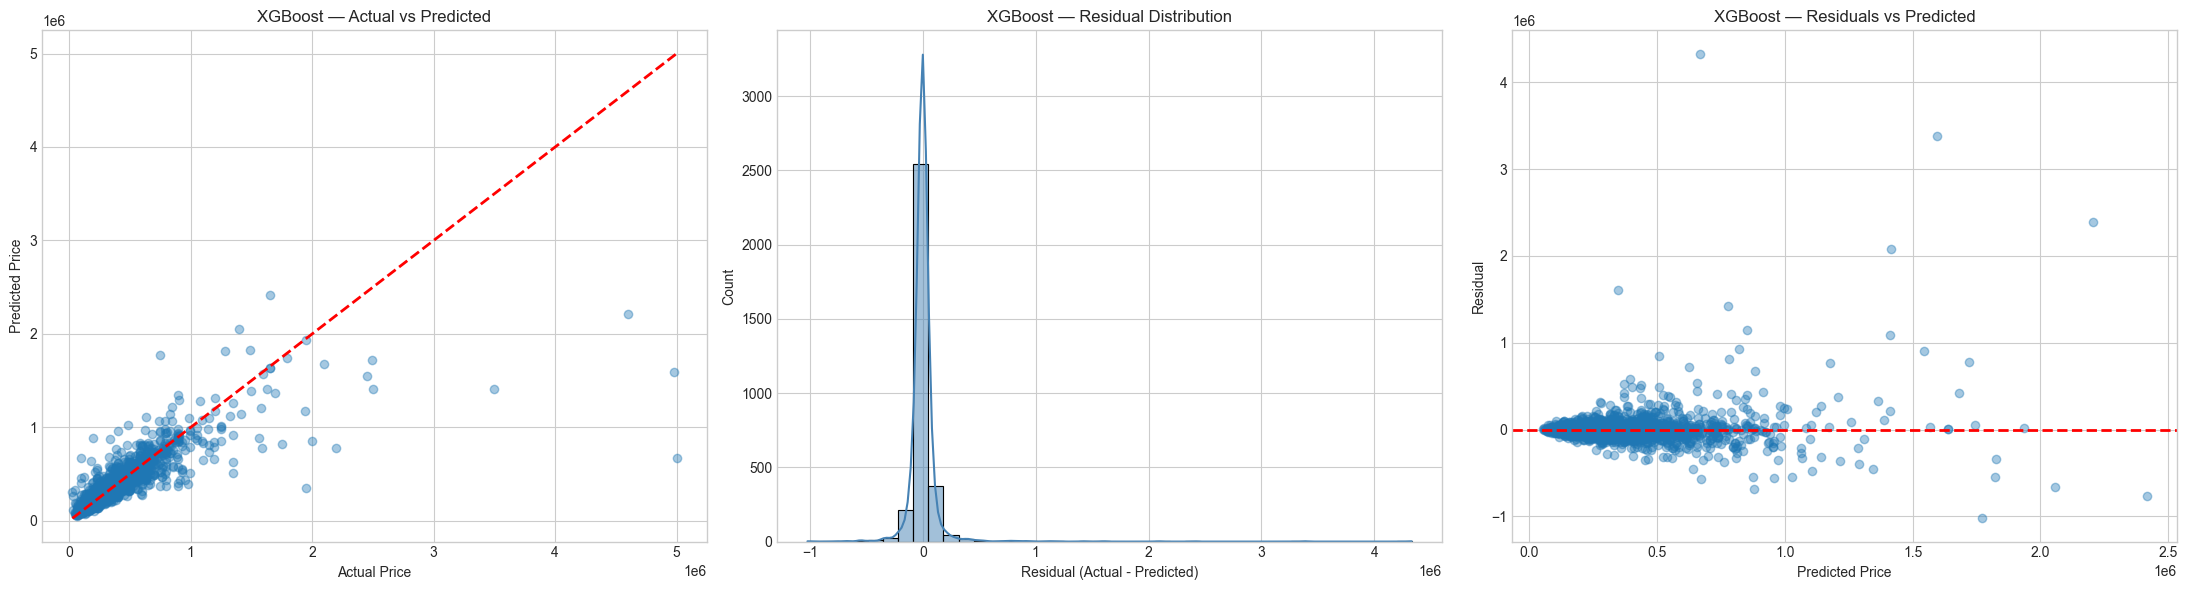

In [11]:
# ============================================================
# XGBOOST REGRESSOR — TRAIN / VAL / TEST
# ============================================================

from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Build X, y (tree-based → use model_type="rf")
X_train_xgb, y_train_xgb = prepare_X_y(df_train, model_type="rf")
X_val_xgb,   y_val_xgb   = prepare_X_y(df_val,   model_type="rf")
X_test_xgb,  y_test_xgb  = prepare_X_y(df_test,  model_type="rf")

print("Shapes (XGBoost):")
print("X_train:", X_train_xgb.shape, " y_train:", y_train_xgb.shape)
print("X_val  :", X_val_xgb.shape,   " y_val  :", y_val_xgb.shape)
print("X_test :", X_test_xgb.shape,  " y_test :", y_test_xgb.shape)

# Pipeline: Imputer + XGBoost
xgb_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),  # optional: XGB handles NaNs
        ("model", XGBRegressor(
            n_estimators=400,
            learning_rate=0.05,
            max_depth=8,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            objective="reg:squarederror"
        ))
    ]
)

# Fit
xgb_pipeline.fit(X_train_xgb, y_train_xgb)

# Predict
y_pred_train_xgb = xgb_pipeline.predict(X_train_xgb)
y_pred_val_xgb   = xgb_pipeline.predict(X_val_xgb)
y_pred_test_xgb  = xgb_pipeline.predict(X_test_xgb)

# Evaluate
print("\n--- XGBoost (Train) ---")
evaluate_regression("XGBoost — Train", y_train_xgb, y_pred_train_xgb)

print("\n--- XGBoost (Validation) ---")
evaluate_regression("XGBoost — Validation", y_val_xgb, y_pred_val_xgb)

print("\n--- XGBoost (Test) ---")
evaluate_regression("XGBoost — Test", y_test_xgb, y_pred_test_xgb)

# Diagnostics on TEST
plot_regression_diagnostics(y_test_xgb, y_pred_test_xgb, title_prefix="XGBoost")


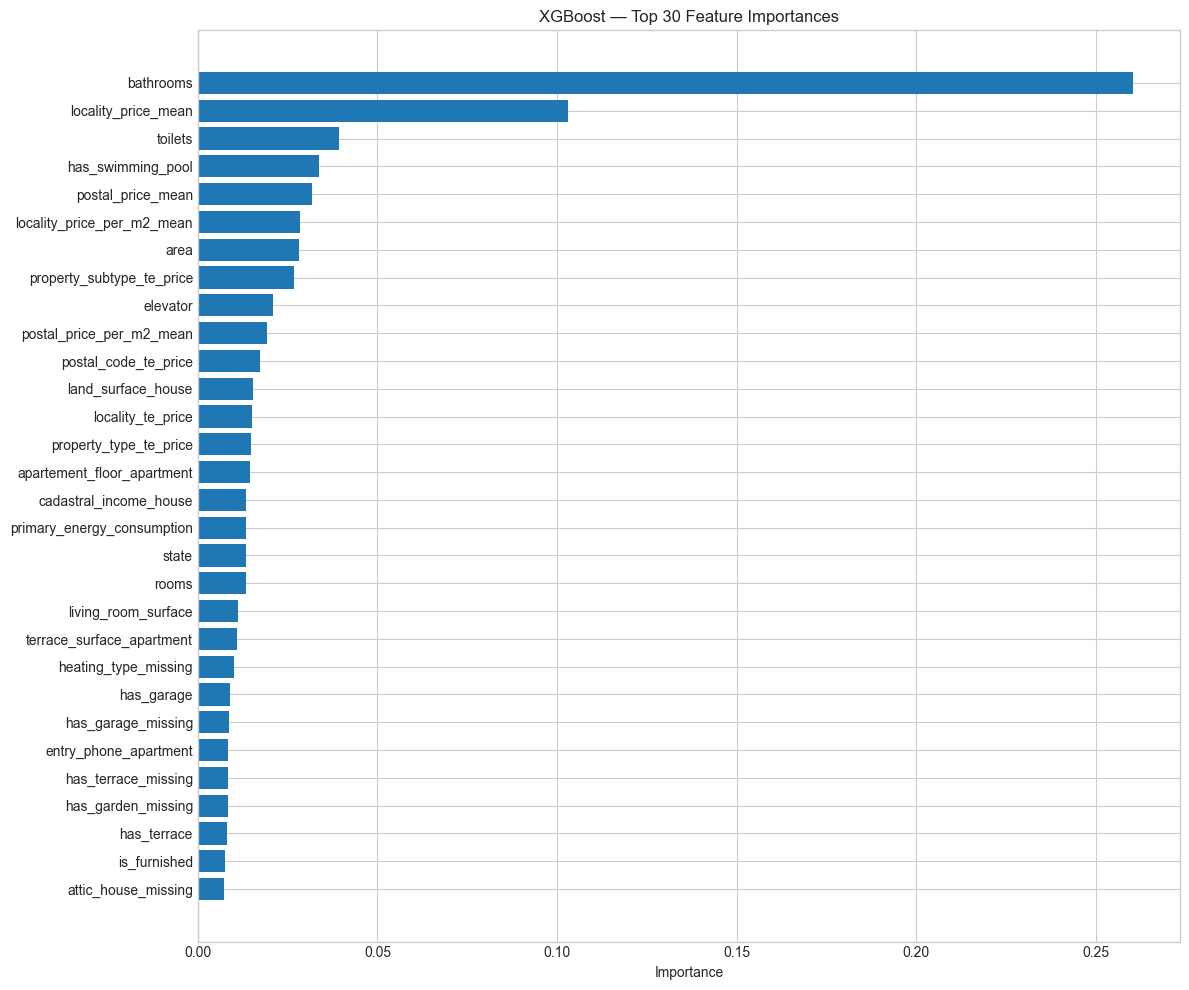

In [11]:
# ============================================================
# XGBOOST FEATURE IMPORTANCE
# ============================================================

xgb_model = xgb_pipeline.named_steps["model"]
importances = xgb_model.feature_importances_

plot_tree_importances(
    xgb_model,
    X_train_xgb.columns,
    top_n=30,
    title="XGBoost — Top 30 Feature Importances"
)


Shapes (LightGBM):
X_train: (15152, 68)  y_train: (15152,)
X_val  : (3247, 68)  y_val  : (3247,)
X_test : (3248, 68)  y_test : (3248,)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3343
[LightGBM] [Info] Number of data points in the train set: 15152, number of used features: 67
[LightGBM] [Info] Start training from score 354734.727891


c:\Users\Chaib\Documents\GitHub\immo-eliza-Amine\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Chaib\Documents\GitHub\immo-eliza-Amine\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Chaib\Documents\GitHub\immo-eliza-Amine\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



--- LightGBM (Train) ---
===== LightGBM — Train =====
MAE: 26,530.10
R² : 0.9640

--- LightGBM (Validation) ---
===== LightGBM — Validation =====
MAE: 58,351.63
R² : 0.7345

--- LightGBM (Test) ---
===== LightGBM — Test =====
MAE: 55,936.45
R² : 0.6704


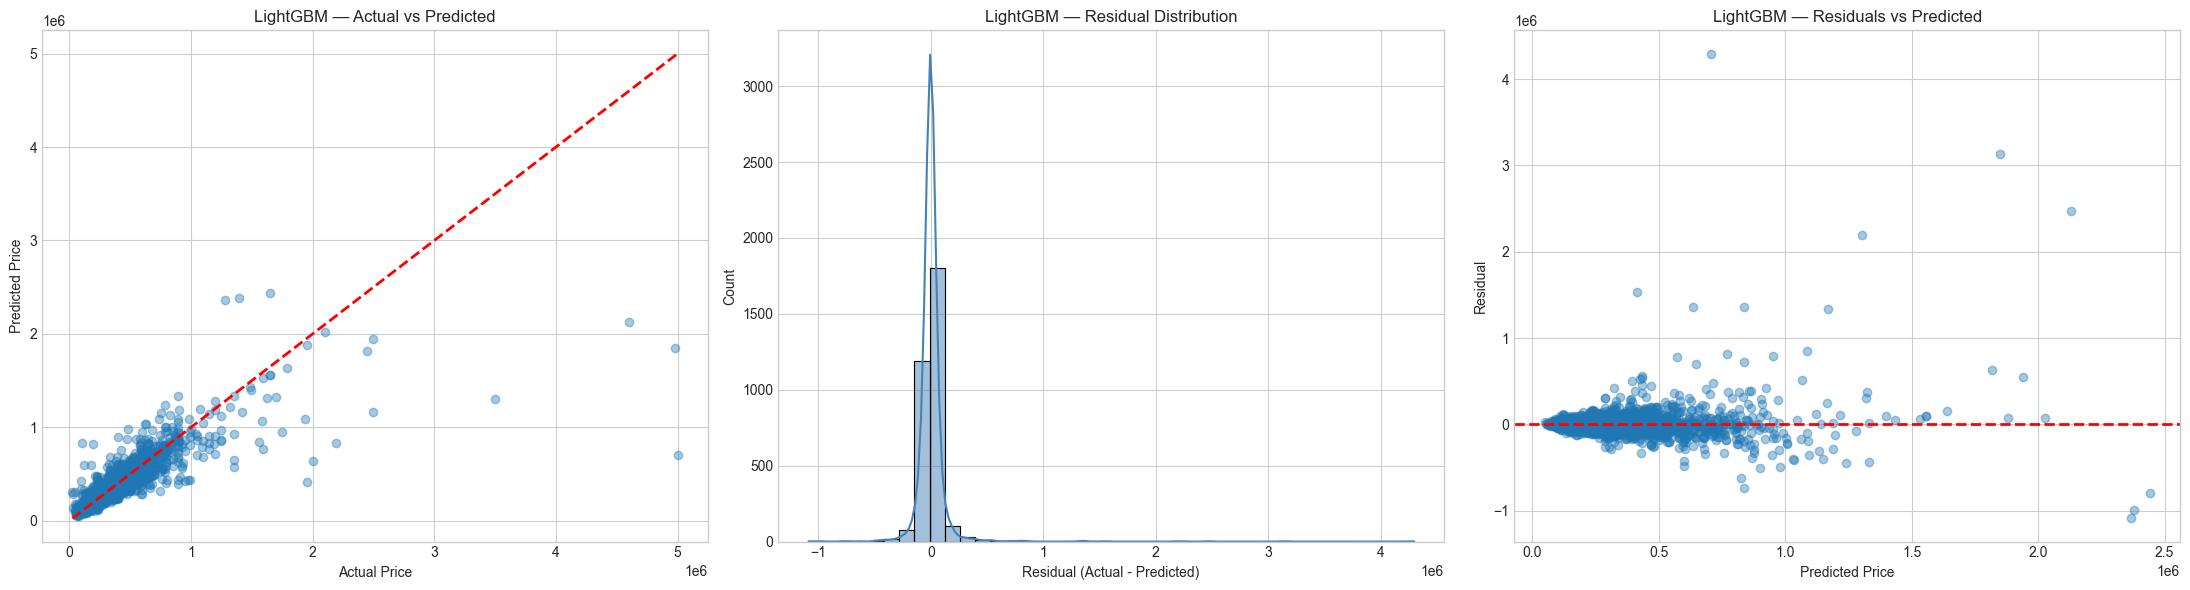

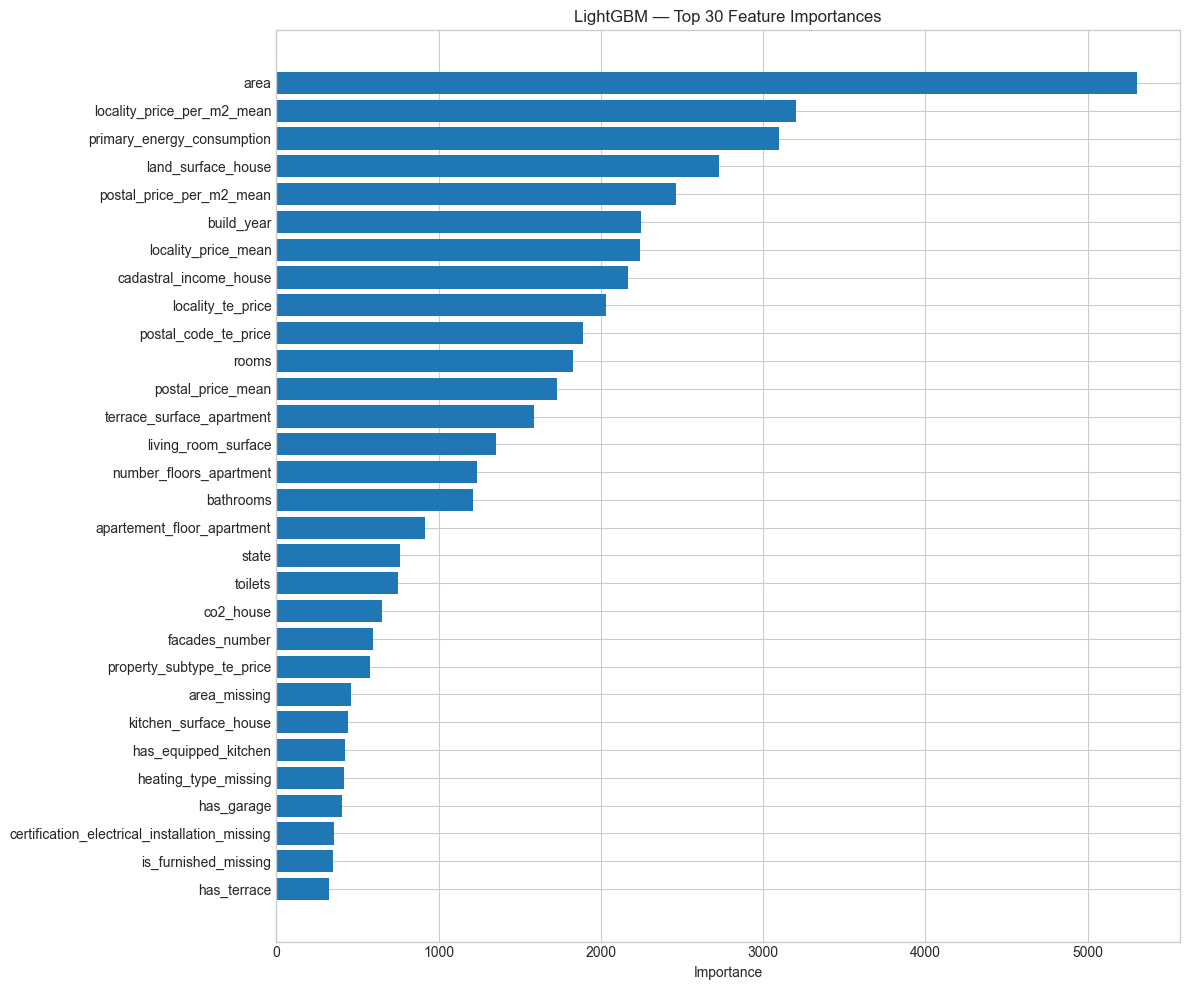

In [10]:
# ============================================================
# LIGHTGBM REGRESSOR — TRAIN / VAL / TEST
# ============================================================

from lightgbm import LGBMRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Build X, y (same as RandomForest/XGBoost: numeric + TE features)
X_train_lgb, y_train_lgb = prepare_X_y(df_train, model_type="rf")
X_val_lgb,   y_val_lgb   = prepare_X_y(df_val,   model_type="rf")
X_test_lgb,  y_test_lgb  = prepare_X_y(df_test,  model_type="rf")

print("Shapes (LightGBM):")
print("X_train:", X_train_lgb.shape, " y_train:", y_train_lgb.shape)
print("X_val  :", X_val_lgb.shape,   " y_val  :", y_val_lgb.shape)
print("X_test :", X_test_lgb.shape,  " y_test :", y_test_lgb.shape)

# ============================================================
# 1. Pipeline: Imputer + LightGBM Model
# ============================================================

lgb_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", LGBMRegressor(
            n_estimators=800,
            learning_rate=0.03,
            max_depth=-1,
            num_leaves=64,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            objective="regression"
        )),
    ]
)

# ============================================================
# 2. Train LightGBM
# ============================================================

lgb_pipeline.fit(X_train_lgb, y_train_lgb)

# ============================================================
# 3. Predict
# ============================================================

y_pred_train_lgb = lgb_pipeline.predict(X_train_lgb)
y_pred_val_lgb   = lgb_pipeline.predict(X_val_lgb)
y_pred_test_lgb  = lgb_pipeline.predict(X_test_lgb)

# ============================================================
# 4. Evaluation
# ============================================================

print("\n--- LightGBM (Train) ---")
evaluate_regression("LightGBM — Train", y_train_lgb, y_pred_train_lgb)

print("\n--- LightGBM (Validation) ---")
evaluate_regression("LightGBM — Validation", y_val_lgb, y_pred_val_lgb)

print("\n--- LightGBM (Test) ---")
evaluate_regression("LightGBM — Test", y_test_lgb, y_pred_test_lgb)

# ============================================================
# 5. Diagnostics on TEST
# ============================================================

plot_regression_diagnostics(
    y_test_lgb, 
    y_pred_test_lgb, 
    title_prefix="LightGBM"
)

# ============================================================
# 6. Feature Importances (Top 30)
# ============================================================

lgb_model = lgb_pipeline.named_steps["model"]
importances = lgb_model.feature_importances_

# Reuse your existing tree importance plotter (works perfectly)
plot_tree_importances(
    lgb_model,
    X_train_lgb.columns,
    top_n=30,
    title="LightGBM — Top 30 Feature Importances"
)


Shapes (CatBoost):
X_train: (15152, 68)  y_train: (15152,)
X_val  : (3247, 68)  y_val  : (3247,)
X_test : (3248, 68)  y_test : (3248,)

--- CatBoost (Train) ---
===== CatBoost — Train =====
MAE: 32,513.68
R² : 0.9605

--- CatBoost (Validation) ---
===== CatBoost — Validation =====
MAE: 58,549.80
R² : 0.7458

--- CatBoost (Test) ---
===== CatBoost — Test =====
MAE: 56,772.08
R² : 0.6609


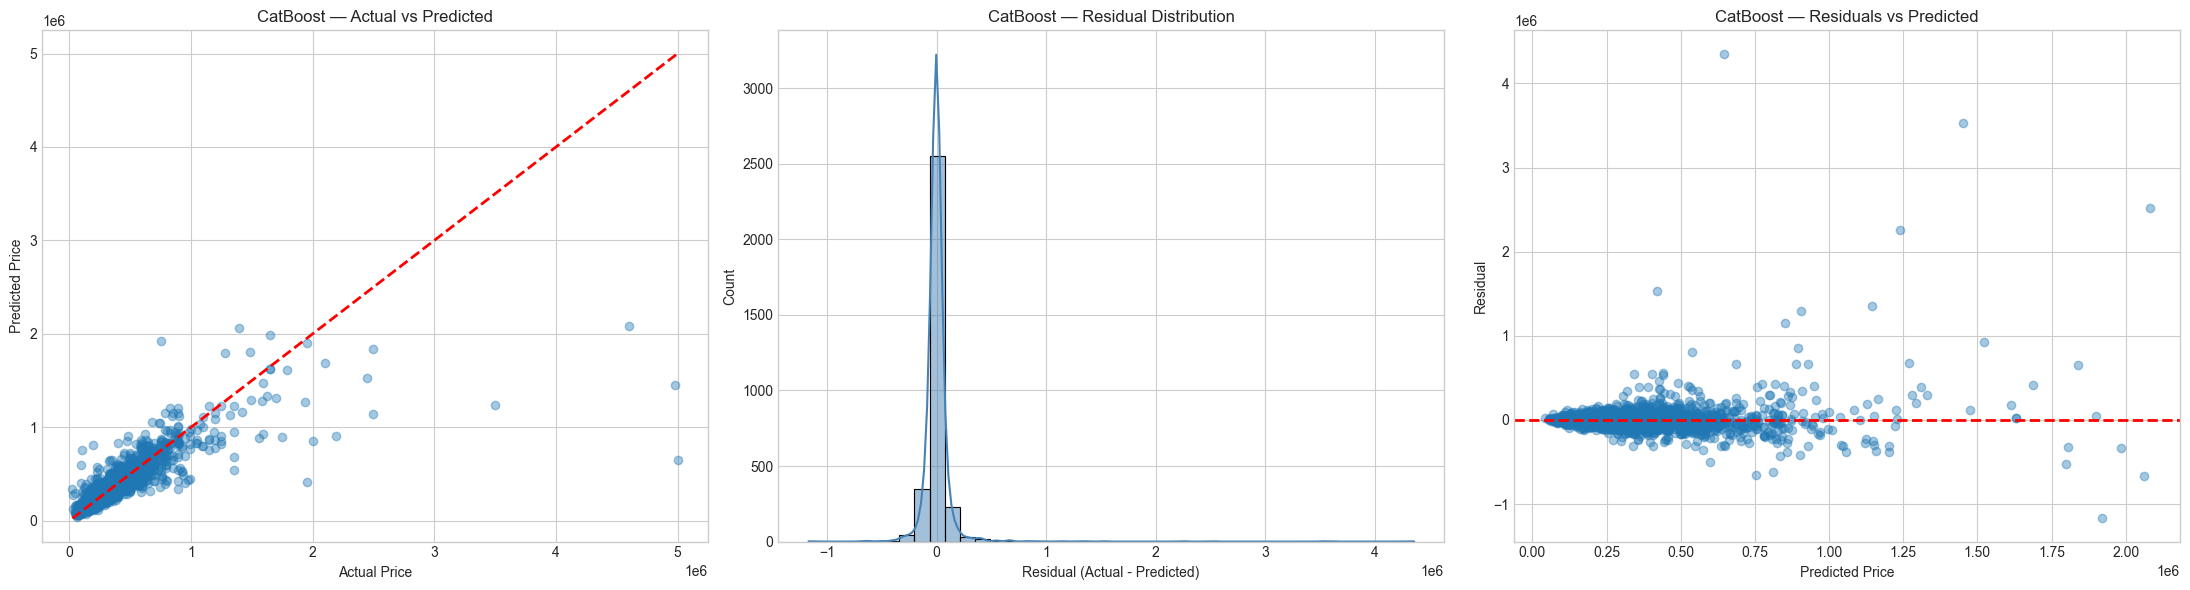

In [12]:
# ============================================================
# CATBOOST REGRESSOR — TRAIN / VAL / TEST
# ============================================================

from catboost import CatBoostRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Build X, y (tree-based → model_type="rf")
X_train_cat, y_train_cat = prepare_X_y(df_train, model_type="rf")
X_val_cat,   y_val_cat   = prepare_X_y(df_val,   model_type="rf")
X_test_cat,  y_test_cat  = prepare_X_y(df_test,  model_type="rf")

print("Shapes (CatBoost):")
print("X_train:", X_train_cat.shape, " y_train:", y_train_cat.shape)
print("X_val  :", X_val_cat.shape,   " y_val  :", y_val_cat.shape)
print("X_test :", X_test_cat.shape,  " y_test :", y_test_cat.shape)

# Pipeline: Imputer + CatBoost
cat_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", CatBoostRegressor(
            iterations=1000,
            learning_rate=0.05,
            depth=8,
            loss_function="RMSE",
            random_seed=42,
            verbose=False
        ))
    ]
)

# Fit
cat_pipeline.fit(X_train_cat, y_train_cat)

# Predict
y_pred_train_cat = cat_pipeline.predict(X_train_cat)
y_pred_val_cat   = cat_pipeline.predict(X_val_cat)
y_pred_test_cat  = cat_pipeline.predict(X_test_cat)

# Evaluate
print("\n--- CatBoost (Train) ---")
evaluate_regression("CatBoost — Train", y_train_cat, y_pred_train_cat)

print("\n--- CatBoost (Validation) ---")
evaluate_regression("CatBoost — Validation", y_val_cat, y_pred_val_cat)

print("\n--- CatBoost (Test) ---")
evaluate_regression("CatBoost — Test", y_test_cat, y_pred_test_cat)

# Diagnostics (on TEST)
plot_regression_diagnostics(y_test_cat, y_pred_test_cat, title_prefix="CatBoost")


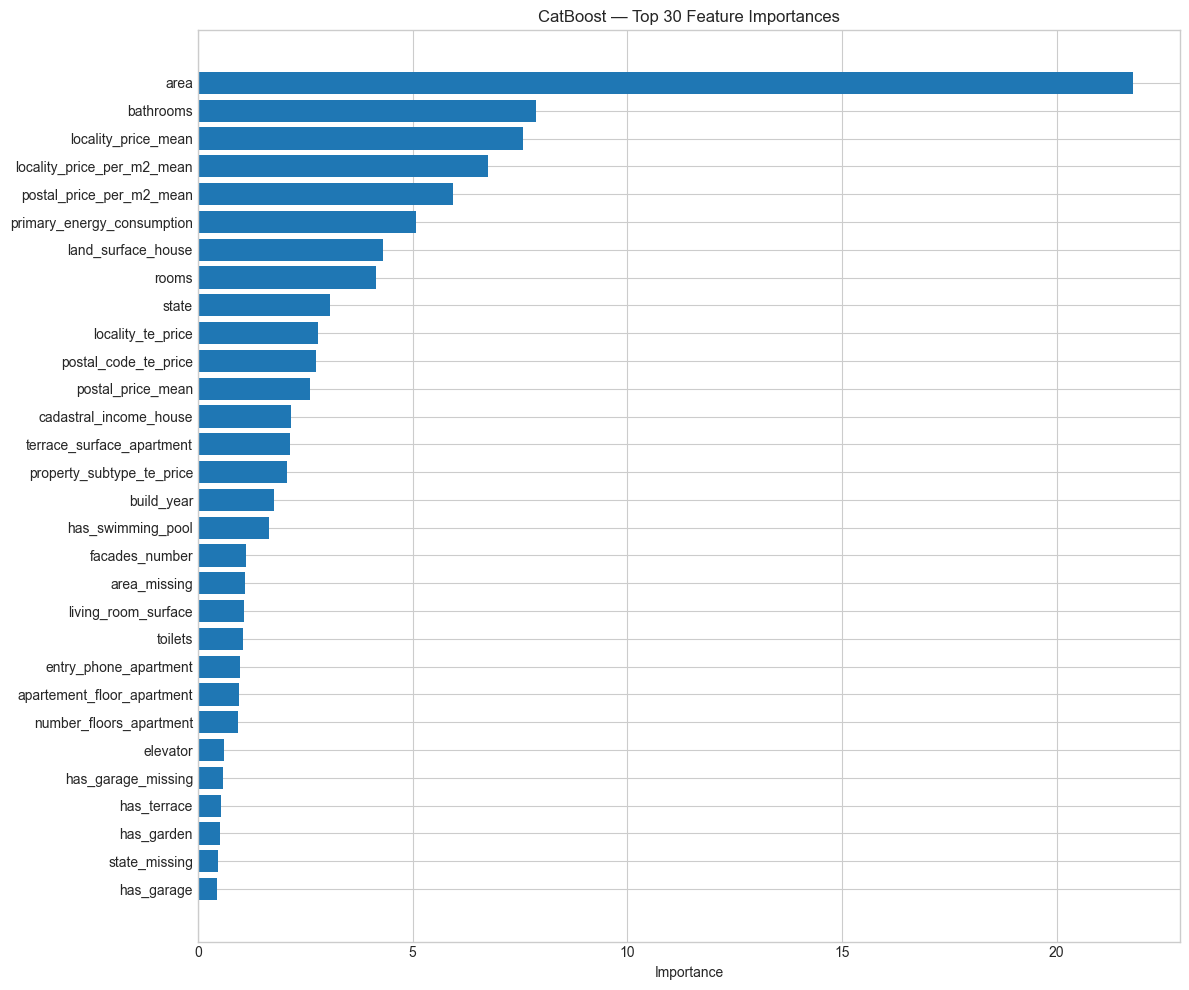

In [13]:
cat_model = cat_pipeline.named_steps["model"]

plot_tree_importances(
    cat_model,
    X_train_cat.columns,
    top_n=30,
    title="CatBoost — Top 30 Feature Importances"
)
